# Initialization

In [2]:
import numpy as np
from matplotlib import pyplot as plt

# for image data handling
import os
from os.path import join, isfile, dirname
from PIL import Image

# Data Handling

### Uncompress compressed files

In [3]:
%%capture
!unzip -n ../data/images.zip -d ../data

### Custom functions

In [4]:
def genFromImage(imageDir, size=(8, 8)):
    dir = dirname(imageDir)
    dataFile = join(dir, "p4_data") + str(size) + ".npy"
    if isfile(dataFile):
        with open(dataFile, 'rb') as f:
            return np.load(f)
    
    labels = os.listdir(imageDir)
    image_data = [[] for _ in labels]
    for label in labels:
        dir = join(imageDir, label)
        files = os.listdir(dir)
        image_data[int(label)] = np.array([np.array(
            Image.open(join(dir, file)).convert("L").resize(size), dtype='uint8'
        ) for file in files])
        
    image_data = np.array(image_data)
    with open(dataFile, 'wb') as f:
        np.save(f, image_data)
    return image_data

# returns X, Y, X_test, Y_test and classStats
def trainTestSplit(data, train_ratio, func):
    n = len(data)
    m = int(np.floor(data.shape[1] * train_ratio))
    classStats = {}
    x_train, y_train, x_test, y_test = [[[] for _ in range(n)] for _ in range(4)]
    for label in range(n):
        x_train[label], y_train[label], classStats[label] = func(label, data[label][:m], True)
        x_test[label], y_test[label] = func(label, data[label][m:])
    
    X, Y, X_test, Y_test = [x.reshape(-1, x.shape[-1]) for x in [np.array(x) for x in [x_train, y_train, x_test, y_test]]]
    return X, np.array(Y.flatten(), dtype=int), X_test, np.array(Y_test.flatten(), dtype=int), classStats

def imgToFeatures(label, data, stats=False):
    X = np.array([x.flatten() for x in data]) / 255
    Y = label * np.ones(data.shape[0])
    if stats:
        return X, Y, { "mean": np.mean(X, axis=0), "cov": np.cov(X.T), "prior": data.shape[0], "data": X }
    return X, Y

def stats(label, data, stats=False):
    X = data
    Y = label * np.ones(data.shape[0])
    if stats:
        return X, Y, { "mean": np.mean(X, axis=0), "cov": np.cov(X.T), "prior": data.shape[0], "data": X }
    return X, Y

### Data extraction

In [5]:
dataFolder = "../data"
imageDir = join(dataFolder, "images")

# p1 = { "testDir": dataFolder + "/p1_test.csv", "trainDir": dataFolder + "/p1_train.csv" } # regression
# p2 = { "testDir": dataFolder + "/p2_test.csv", "trainDir": dataFolder + "/p2_train.csv" } # regression
p3 = { "testDir": dataFolder + "/p3_test.csv", "trainDir": dataFolder + "/p3_train.csv" } # classification
p4 = {}                                                                                   # classification
p5 = {}                                                                                   # classification

# p1["test"] = np.genfromtxt(p1["testDir"], delimiter=',')
# p1["train"] = np.genfromtxt(p1["trainDir"], delimiter=',')
# p2["test"] = np.genfromtxt(p2["testDir"], delimiter=',')
# p2["train"] = np.genfromtxt(p2["trainDir"], delimiter=',')
p3["test"] = np.genfromtxt(p3["testDir"], delimiter=',')
p3["train"] = np.genfromtxt(p3["trainDir"], delimiter=',')
p4["data"] = genFromImage(imageDir)
p5["data"] = np.genfromtxt(dataFolder + "/PCA_MNIST.csv", delimiter=',')[1:]

print("--------------------------- Data Shapes ------------------------------")
# print("    (Regression) p1[train]:      ", p1["train"].shape, ", p1[test]: ", p1["test"].shape)
# print("    (Regression) p2[train]:      ", p2["train"].shape, ", p2[test]: ", p2["test"].shape)
print("(Classification) p3[train]:     ", p3["train"].shape, ", p3[test]: ", p3["test"].shape)
print("(Classification)  p4[data]:", p4["data"].shape)
print("(Classification)  p5[data]:     ", p5["data"].shape)

--------------------------- Data Shapes ------------------------------
(Classification) p3[train]:      (60000, 11) , p3[test]:  (15000, 11)
(Classification)  p4[data]: (10, 6000, 8, 8)
(Classification)  p5[data]:      (60000, 11)


In [6]:
classStats = {}
for row in p3["train"]:
    label = int(row[-1]) - 1
    if label in classStats:
        classStats[label].append(row[:-1])
    else:
        classStats[label] = [row[:-1]]

# classStats = [np.array(data) for data in classStats]
for i in range(len(classStats)):
    data = np.array(classStats[i])
    classStats[i] = { "mean": np.mean(data, axis=0), "cov": np.cov(data.T), "prior": data.shape[0], "data": data }
    
def splitData(data):
    # X = np.array([normalize(col) for col in data.T[:-1]]).T
    X = data.T[:-1].T
    Y = data.T[-1].T.astype("int") - 1
    return X, Y

p3["classStats"] = classStats
p3["X"], p3["Y"] = splitData(p3["train"])
p3["X_test"], p3["Y_test"] = splitData(p3["test"])

p3["X"].shape, p3["Y"].shape, p3["X_test"].shape, p3["Y_test"].shape

((60000, 10), (60000,), (15000, 10), (15000,))

In [7]:
p4["X"], p4["Y"], p4["X_test"], p4["Y_test"], p4["classStats"] = trainTestSplit(p4["data"], 0.7, imgToFeatures)

p4["X"].shape, p4["Y"].shape, p4["X_test"].shape, p4["Y_test"].shape

((42000, 64), (42000,), (18000, 64), (18000,))

In [8]:
classWiseData = [[] for _ in range(10)]
for row in p5["data"]:
    label = int(row[0])
    classWiseData[label].append(row[1:])
    
p5["X"], p5["Y"], p5["X_test"], p5["Y_test"], p5["classStats"] = trainTestSplit(np.array(classWiseData), 0.5, stats)
p5["X"].shape, p5["Y"].shape, p5["X_test"].shape, p5["Y_test"].shape

((30000, 10), (30000,), (30000, 10), (30000,))

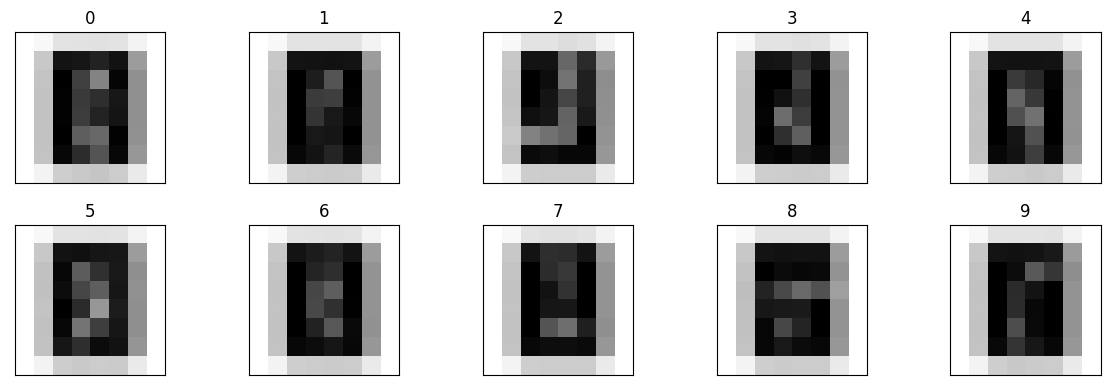

In [9]:
fig, ax = plt.subplots(2, 5, figsize=(12, 4))
for i in range(p4["data"].shape[0]):
    ax[i // 5][i % 5].imshow(p4["data"][i][0].astype(np.uint8), cmap='gray')
    ax[i // 5][i % 5].set_title(str(i))
    ax[i // 5][i % 5].get_xaxis().set_visible(False)
    ax[i // 5][i % 5].get_yaxis().set_visible(False)

fig.tight_layout()

# Metrics

In [35]:
class metrics:
    def accuracy(predicted, actual):
        m = actual.size
        correctCount = sum([1 if int(predicted[i]) == int(actual[i]) else 0 for i in range(m)])
        return correctCount / m
    
    def confusionMatrix(predicted, actual, n = 5):
        cnf = np.zeros((n, n), dtype='uint')
        for i in range(actual.size):
            cnf[int(actual[i])][int(predicted[i])] += 1
        return cnf
    
    def f1Score(cnf):
        sum_predict = np.sum(cnf, axis=0)
        sum_actual  = np.sum(cnf, axis=1)
        p = np.zeros(cnf.shape[1])
        r = np.zeros(cnf.shape[1])
        f1 = np.zeros(cnf.shape[1])
        for i in range(f1.size):
            TP = cnf[i][i]
            FP, FN = sum_predict[i] - TP, sum_actual[i] - TP
            p[i], r[i] = TP/(TP + FP + 1e-8), TP/(TP + FN + 1e-8)
            f1[i] = 2 * p[i] * r[i] / (p[i] + r[i] + 1e-8)
        return f1, p, r 

    def printCnf(cnf_train, cnf_test):
        print("Confusion Matrix:")
        print(cnf_test)
        
        fig, ax = plt.subplots(1, 2, figsize=(16, 8))
        ax[0].matshow(cnf_train.T, cmap='GnBu')
        ax[0].set_xlabel("Predicted")
        ax[0].set_ylabel("Actual")
        ax[0].set_title("Confusion Matrix (train)")
        for (x, y), value in np.ndenumerate(cnf_train):
            ax[0].text(x, y, f"{value: .0f}", va="center", ha="center")
        
        ax[1].matshow(cnf_test.T, cmap='GnBu')
        ax[1].set_xlabel("Predicted")
        ax[1].set_ylabel("Actual")
        ax[1].set_title("Confusion Matrix (test)")
        for (x, y), value in np.ndenumerate(cnf_test):
            ax[1].text(x, y, f"{value: .0f}", va="center", ha="center")

    
    def print(pred, Y, pred_test, Y_test, visualize=True, result=False):
        n_labels = len(np.unique(Y))
                
        cnf_train = metrics.confusionMatrix(pred, Y, n_labels)
        cnf_test = metrics.confusionMatrix(pred_test, Y_test, n_labels)
        acc_train = metrics.accuracy(pred, Y)
        acc_test = metrics.accuracy(pred_test, Y_test)
        f1_train, p_train, r_train = metrics.f1Score(cnf_train)
        f1_test, p_test, r_test = metrics.f1Score(cnf_test)
        
        if visualize:
            print("------------------ Train ---------------------")
            print(f"Classification Accuracy : {acc_train * 100:.2f}%")
            print(f"Average F1 Score        : {np.average(f1_train):.2f}")
            print(f"Average Precision       : {np.average(p_train):.2f}")
            print(f"Average Recall          : {np.average(r_train):.2f}")
            print("------------------ Test ----------------------")
            print(f"Classification Accuracy : {acc_test * 100:.2f}%")
            print(f"Average F1 Score        : {np.average(f1_test):.2f}")
            print(f"Average Precision       : {np.average(p_test):.2f}")
            print(f"Average Recall          : {np.average(r_test):.2f}")
            
            metrics.printCnf(cnf_train, cnf_test)
        
        if result:
            return [acc_train, f1_train, p_train, r_train, cnf_train], [acc_test, f1_test, p_test, r_test, cnf_test]

# Problem 1

Implement classification trees using Gini impurity and cross-entropy as impurity functions with different depths. 

For the MNIST problem, consider the PCA data

Data: `p3, p5`

## Implementation

### Impurity Funcions

In [11]:
def gini(data):
    n = data.shape[0]
    if n == 0:
        return 0
    p = np.bincount(data) / n
    return 1 - np.sum(p ** 2)

print("Gini (test): ", gini(p3["Y"]), gini(p3['Y'][p3["Y"] == 0]))

def entropy(data):
    n = data.shape[0]
    if n == 0:
        return 0
    p = np.bincount(data) / n
    return -np.sum(p * np.log2(p + 1e-8))

print("Entropy (test): ", entropy(p3["Y"]), entropy(p3['Y'][p3["Y"] == 0]))

Gini (test):  0.7999987455555555 0.0
Entropy (test):  2.3219234968181315 -1.442695024907551e-08


### CART algorithm

In [12]:
# restricting the number of thresholds to increase the speed of the algorithm
def recommendedThresholds(col, y):
    a = np.c_[col, y]
    a.sort(axis=0)
    b = []
    for i in range(1, a.shape[0]):
        if a[i][1] != a[i - 1][1]:
            b.append((a[i][0] + a[i - 1][0]) / 2)
    return b

def recommendedSplit(X, y, impurity, skip_features_idx=[]):
    best_impurity = 1e9
    best_split = None
    for i, col in enumerate(X.T):
        if i in skip_features_idx:
            continue
        ts = recommendedThresholds(col, y)
        for t in ts:
            left, right = y[col <= t], y[col > t]
            impurity_split = (impurity(left) * left.size + impurity(right) * right.size) / y.size
            if impurity_split < best_impurity:
                best_impurity = impurity_split
                best_split = (i, t)
    return best_split

recommendedSplit(p3["X"], p3["Y"], gini)

(5, 1.3925129339837405)

### Decision Tree

In [71]:
# inner nodes are [i, t, left, right]
# leaf node is a number (class label)
# returns a tree in pre-order traversal format
def buildTree(X, y, impurity, max_depth, depth=0, skip_features_idx=[]):
    if depth == max_depth:
        return [np.argmax(np.bincount(y))]
    if np.unique(y).size == 1:
        return [y[0]]
    
    split = recommendedSplit(X, y, impurity, skip_features_idx)

    if split is None:
        return [np.argmax(np.bincount(y))]
    
    i, t = split
    left, right = y[X[:, i] <= t], y[X[:, i] > t]
    leftX, rightX = X[X[:, i] <= t], X[X[:, i] > t]

    if left.size == 0 or right.size == 0:
        return [np.argmax(np.bincount(y))]
    
    return [split, buildTree(leftX, left, impurity, max_depth, depth + 1), buildTree(rightX, right, impurity, max_depth, depth + 1)]

def printTree(tree, depth=0):
    if len(tree) == 1:
        print(" " * depth, "Leaf: ", tree[0])
    else:
        print(" " * depth, f"Split: {tree[0][0]:.2f} <=  {tree[0][1]:.2f}")
        printTree(tree[1], depth + 1)
        printTree(tree[2], depth + 1)

def predict(X, tree):
    if len(tree) == 1:
        return tree[0]
    i, t = tree[0]
    return predict(X, tree[1]) if X[i] <= t else predict(X, tree[2])
    
def predictAll(X, tree):
    return np.array([predict(x, tree) for x in X])


## Experiment on P3 Data

### Using Gini as impurity measure

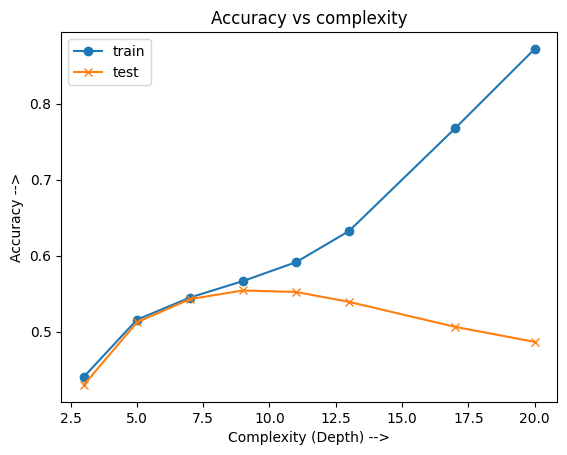

In [47]:
depths = [3, 5, 7, 9, 11, 13, 17, 20]
results = []

for depth in depths:
    tree = buildTree(p3["X"], p3["Y"], gini, depth)
    results.append(metrics.print(predictAll(p3["X"], tree), p3["Y"], predictAll(p3["X_test"], tree), p3["Y_test"], visualize=False, result=True))

bestResult_p3_gini = results[np.argmax([row[1][0] for row in results])]

plt.plot(depths, [row[0][0] for row in results], label="train", marker='o')
plt.plot(depths, [row[1][0] for row in results], label="test", marker='x')
plt.xlabel("Complexity (Depth) -->")
plt.ylabel("Accuracy -->")
plt.legend()
plt.title("Accuracy vs complexity")

plt.show()

Test Accuracy: 55.42%, Precision: 0.57, Recall: 0.55, F1 Score: 0.56
Confusion Matrix:
[[1551  589  251  287  293]
 [ 413 1808  275  262  223]
 [ 339  506 1804  198  193]
 [ 354  574  262 1608  177]
 [ 380  609  230  272 1542]]


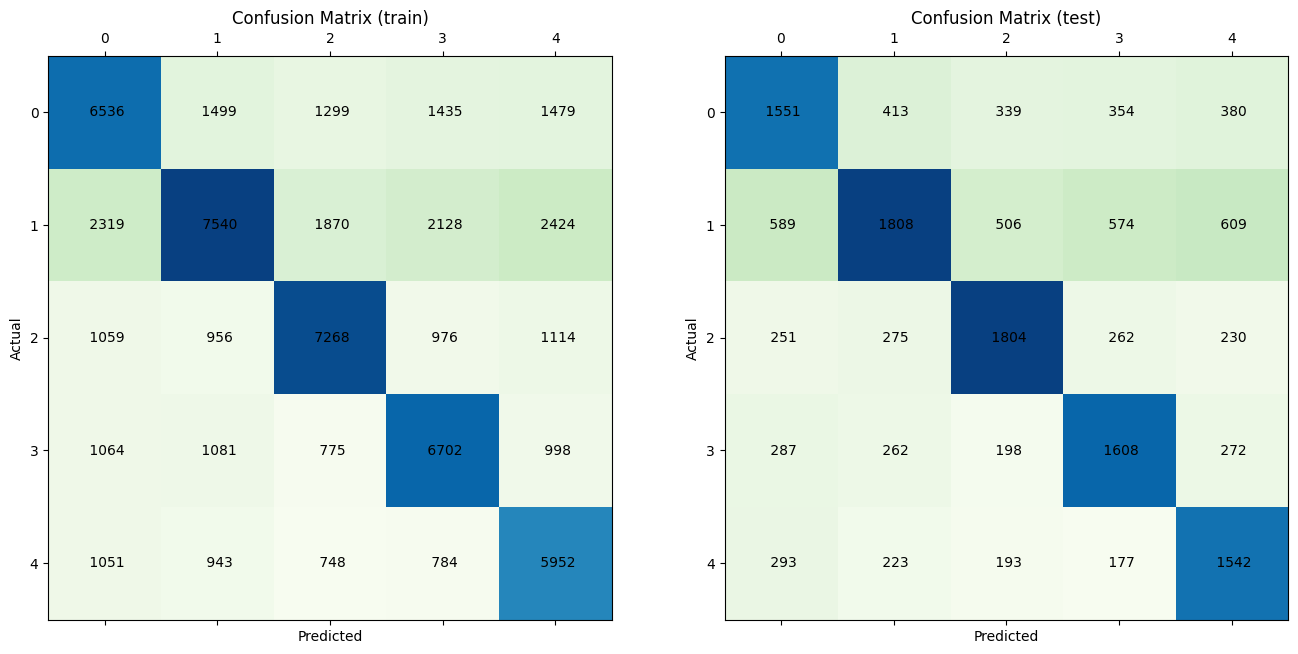

In [48]:
print(f"Test Accuracy: {bestResult_p3_gini[1][0] * 100:.2f}%, Precision: {np.average(bestResult_p3_gini[1][2]):.2f}, Recall: {np.average(bestResult_p3_gini[1][3]):.2f}, F1 Score: {np.average(bestResult_p3_gini[1][1]):.2f}")
metrics.printCnf(bestResult_p3_gini[0][4], bestResult_p3_gini[1][4])

### Using Cross-Entropy as impurity measure

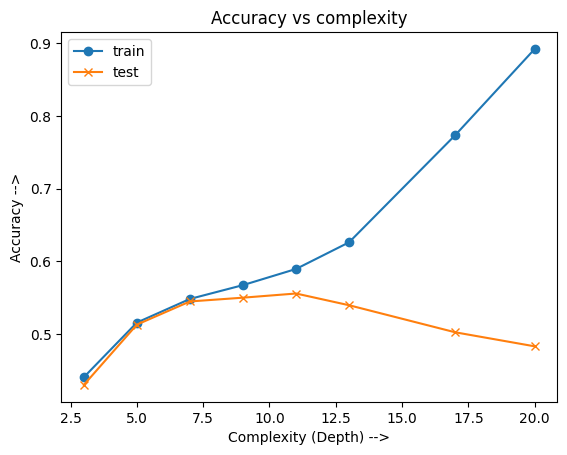

In [49]:
depths = [3, 5, 7, 9, 11, 13, 17, 20]
results = []

for depth in depths:
    tree = buildTree(p3["X"], p3["Y"], entropy, depth)
    results.append(metrics.print(predictAll(p3["X"], tree), p3["Y"], predictAll(p3["X_test"], tree), p3["Y_test"], visualize=False, result=True))

bestResult_p3_entropy = results[np.argmax([row[1][0] for row in results])]

plt.plot(depths, [row[0][0] for row in results], label="train", marker='o')
plt.plot(depths, [row[1][0] for row in results], label="test", marker='x')
plt.xlabel("Complexity (Depth) -->")
plt.ylabel("Accuracy -->")
plt.legend()
plt.title("Accuracy vs complexity")

plt.show()

Test Accuracy: 55.57%, Precision: 0.56, Recall: 0.56, F1 Score: 0.56
Confusion Matrix:
[[1599  371  240  330  431]
 [ 473 1604  259  265  380]
 [ 377  327 1744  221  371]
 [ 422  350  236 1655  312]
 [ 431  348  202  319 1733]]


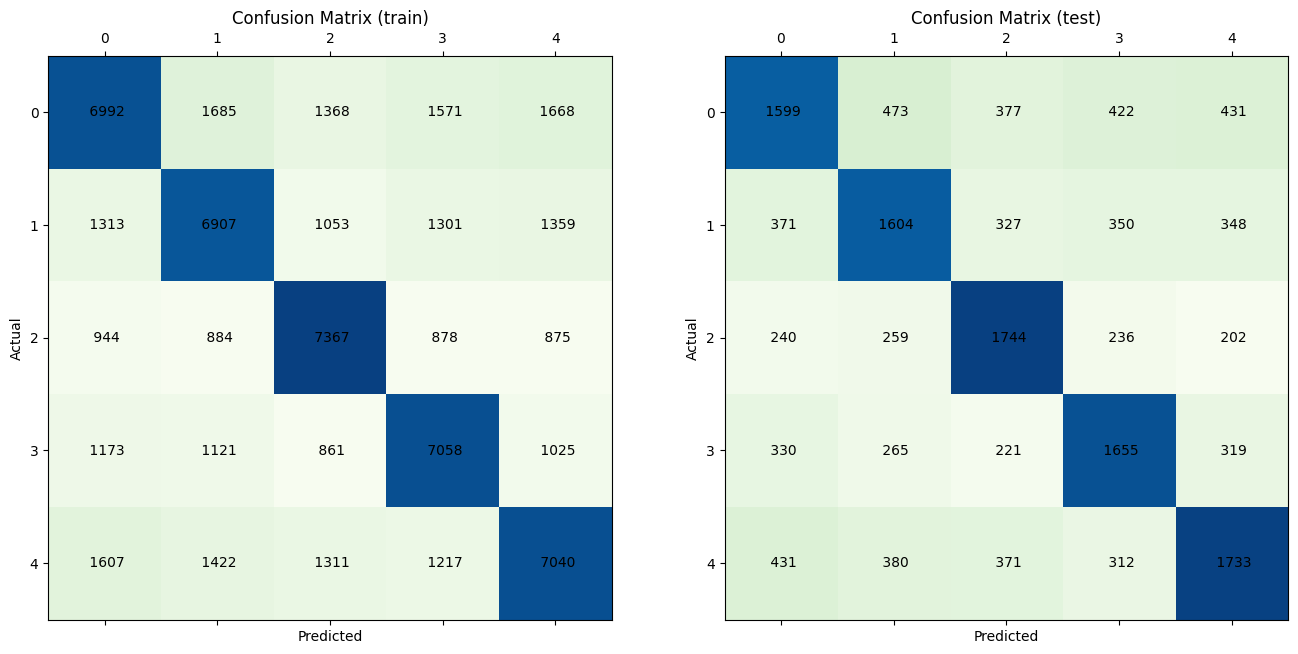

In [50]:
print(f"Test Accuracy: {bestResult_p3_entropy[1][0] * 100:.2f}%, Precision: {np.average(bestResult_p3_entropy[1][2]):.2f}, Recall: {np.average(bestResult_p3_entropy[1][3]):.2f}, F1 Score: {np.average(bestResult_p3_entropy[1][1]):.2f}")
metrics.printCnf(bestResult_p3_entropy[0][4], bestResult_p3_entropy[1][4])

## Experiment on P5 Data (MNIST PCA)

### Using Gini as impurity measure

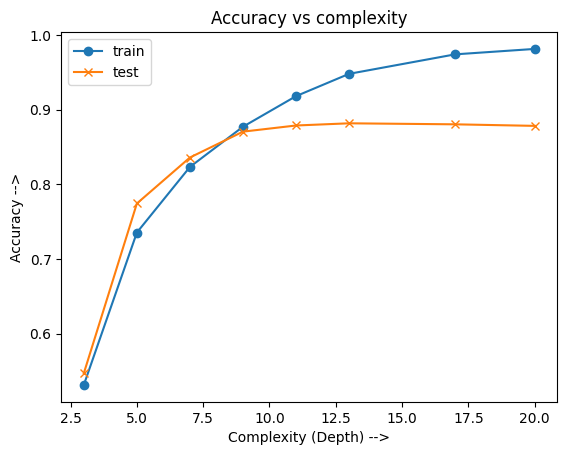

In [51]:
depths = [3, 5, 7, 9, 11, 13, 17, 20]
results = []

for depth in depths:
    tree = buildTree(p5["X"], p5["Y"], gini, depth)
    results.append(metrics.print(predictAll(p5["X"], tree), p5["Y"], predictAll(p5["X_test"], tree), p5["Y_test"], visualize=False, result=True))

bestResult_p5_gini = results[np.argmax([row[1][0] for row in results])]

plt.plot(depths, [row[0][0] for row in results], label="train", marker='o')
plt.plot(depths, [row[1][0] for row in results], label="test", marker='x')
plt.xlabel("Complexity (Depth) -->")
plt.ylabel("Accuracy -->")
plt.legend()
plt.title("Accuracy vs complexity")

plt.show()

Test Accuracy: 88.18%, Precision: 0.88, Recall: 0.88, F1 Score: 0.88
Confusion Matrix:
[[2608  219   23   21    3    6    5   19   68   28]
 [ 197 2648   10   23   34    6    4   25   26   27]
 [   8    6 2858   14    0   56    4    6    9   39]
 [  37   44   62 2633   26   60   44   52   29   13]
 [   2    1    1   50 2715  132   12   28    7   52]
 [   6   11   25   42  148 2676    5   11   68    8]
 [   4    0   10   41    9    8 2623  290    3   12]
 [   4    4   75  152   12    9  411 2314    1   18]
 [  94    9    6    4   20   14    4    5 2808   36]
 [  64   51   24   22   90   20   32   69   57 2571]]


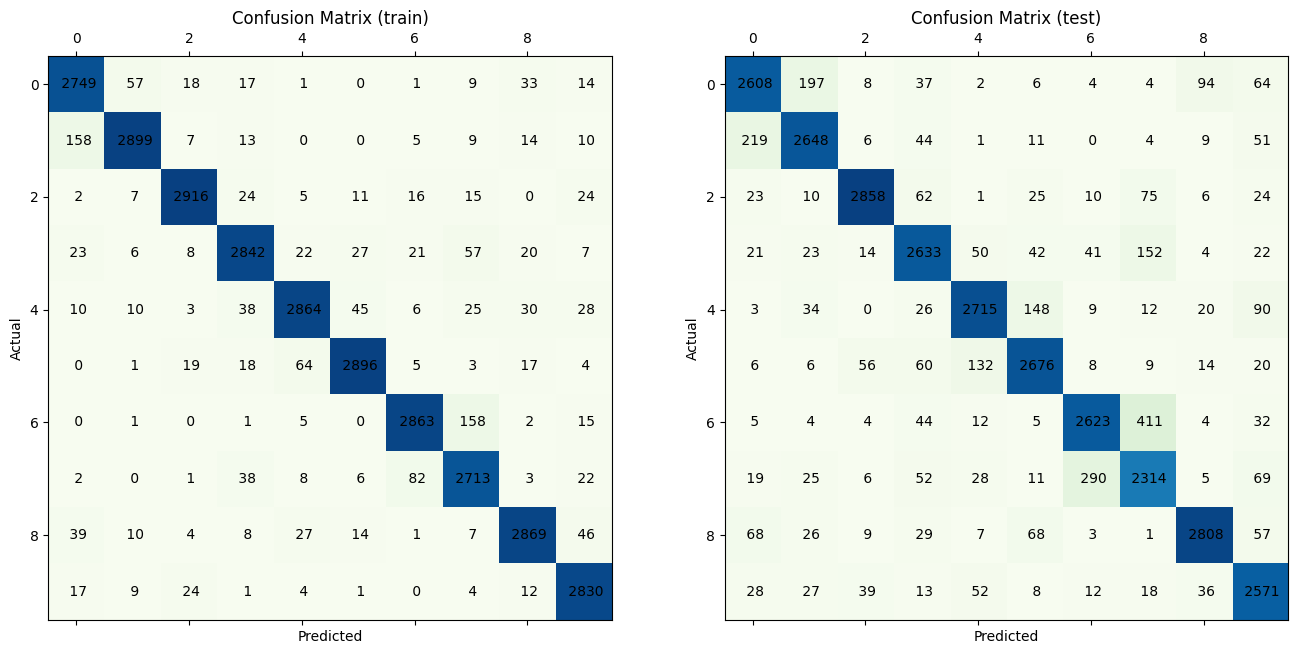

In [52]:
print(f"Test Accuracy: {bestResult_p5_gini[1][0] * 100:.2f}%, Precision: {np.average(bestResult_p5_gini[1][2]):.2f}, Recall: {np.average(bestResult_p5_gini[1][3]):.2f}, F1 Score: {np.average(bestResult_p5_gini[1][1]):.2f}")
metrics.printCnf(bestResult_p5_gini[0][4], bestResult_p5_gini[1][4])

### Using Entropy as impurity measure

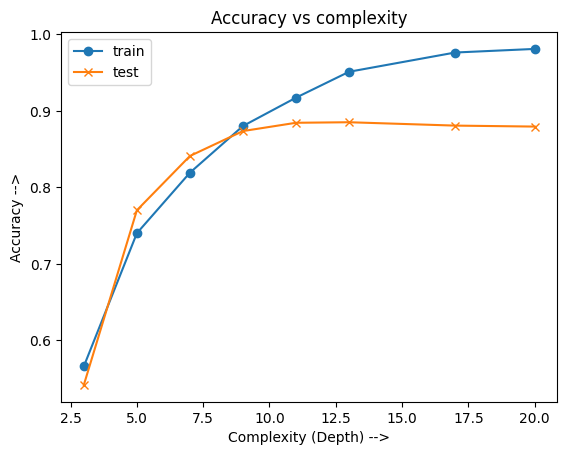

In [53]:
depths = [3, 5, 7, 9, 11, 13, 17, 20]
results = []

for depth in depths:
    tree = buildTree(p5["X"], p5["Y"], entropy, depth)
    results.append(metrics.print(predictAll(p5["X"], tree), p5["Y"], predictAll(p5["X_test"], tree), p5["Y_test"], visualize=False, result=True))

bestResult_p5_entropy = results[np.argmax([row[1][0] for row in results])]

plt.plot(depths, [row[0][0] for row in results], label="train", marker='o')
plt.plot(depths, [row[1][0] for row in results], label="test", marker='x')
plt.xlabel("Complexity (Depth) -->")
plt.ylabel("Accuracy -->")
plt.legend()
plt.title("Accuracy vs complexity")

plt.show()

Test Accuracy: 88.52%, Precision: 0.89, Recall: 0.89, F1 Score: 0.89
Confusion Matrix:
[[2612  218   13   34    6    2    3   12   83   17]
 [ 198 2641   15   34   16    4    8   13   44   27]
 [  12    9 2825   18    3   71    5    9   12   36]
 [  26   24   75 2644   27   49   36   71   32   16]
 [   2    2    6   43 2716  119   12   41   21   38]
 [   6   21   60   47  124 2628    8   19   63   24]
 [   3    0   14   40    3   16 2595  305    3   21]
 [   5    0   20  128   19    4  339 2466    0   19]
 [  72   15   10    4   22    8    2    2 2818   47]
 [  52   35   20   15   51   30   29   71   87 2610]]


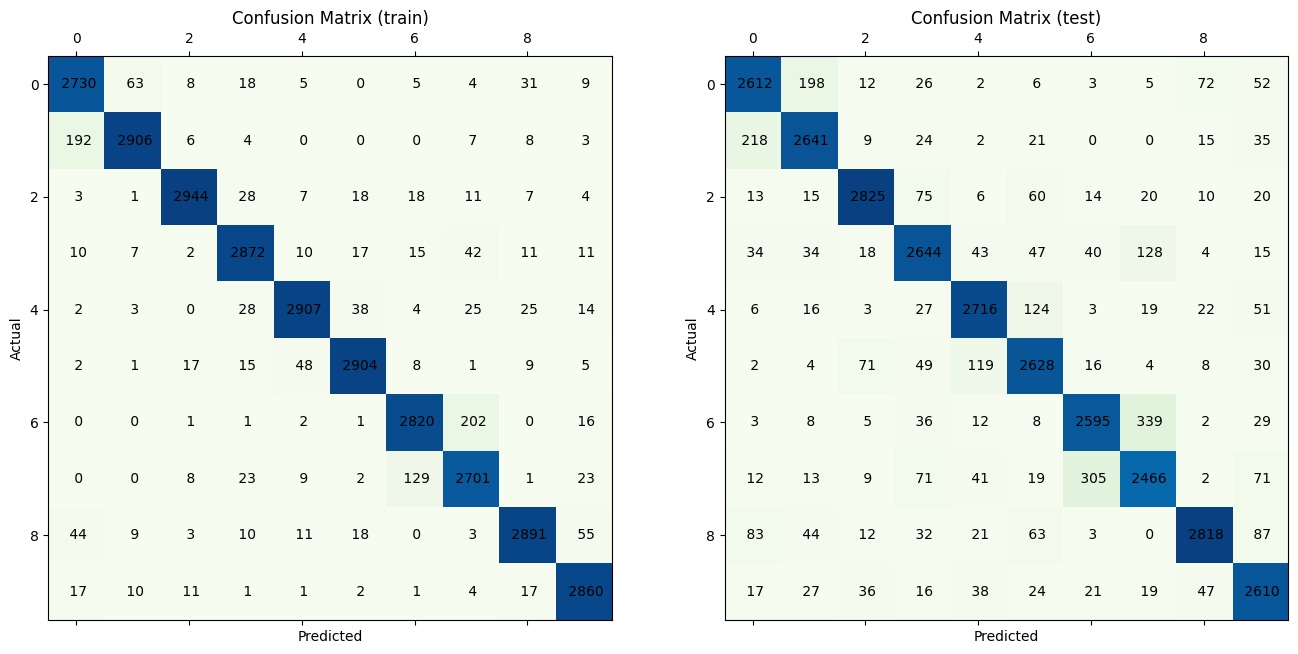

In [54]:
print(f"Test Accuracy: {bestResult_p5_entropy[1][0] * 100:.2f}%, Precision: {np.average(bestResult_p5_entropy[1][2]):.2f}, Recall: {np.average(bestResult_p5_entropy[1][3]):.2f}, F1 Score: {np.average(bestResult_p5_entropy[1][1]):.2f}")
metrics.printCnf(bestResult_p5_entropy[0][4], bestResult_p5_entropy[1][4])

# Problem 2

Implement Random forest Algorithm with varying numbers of trees and features and report your observations

Data: `p3, p4, p5`

## Implementation

In [14]:
def bootstrap(X, Y):
    n = len(X)
    idx = np.random.choice(n, n, replace=False)
    return X[idx], Y[idx]

def random_forest(X, Y, n_trees=10, depth=5, impurity=gini, n_features=None):
    trees = []
    for _ in range(n_trees):
        X_train, Y_train = bootstrap(X, Y)
        idx = [] if n_features is None else np.random.choice(X_train.shape[1], X_train.shape[1] - n_features, replace=False)
        trees.append(buildTree(X_train, Y_train, impurity, depth, skip_features_idx=idx))
    return trees

def predictForest(X, trees):
    predictions = np.array([predictAll(X, tree) for tree in trees])
    return np.array([np.bincount(prediction).argmax() for prediction in predictions.T])

def predictForestProb(X, trees):
    predictions = np.array([predictAll(X, tree) for tree in trees])
    return np.array([np.bincount(prediction) / len(prediction) for prediction in predictions.T])



## Experiment on P3 data

### Number of trees: 10, Number of features: 10

------------------ Train ---------------------
Classification Accuracy : 69.32%
Average F1 Score        : 0.69
Average Precision       : 0.69
Average Recall          : 0.69
------------------ Test ----------------------
Classification Accuracy : 52.25%
Average F1 Score        : 0.52
Average Precision       : 0.52
Average Recall          : 0.52
Confusion Matrix:
[[1356  504  364  370  377]
 [ 382 1604  323  319  353]
 [ 322  383 1757  275  303]
 [ 326  400  325 1643  281]
 [ 405  465  333  353 1477]]


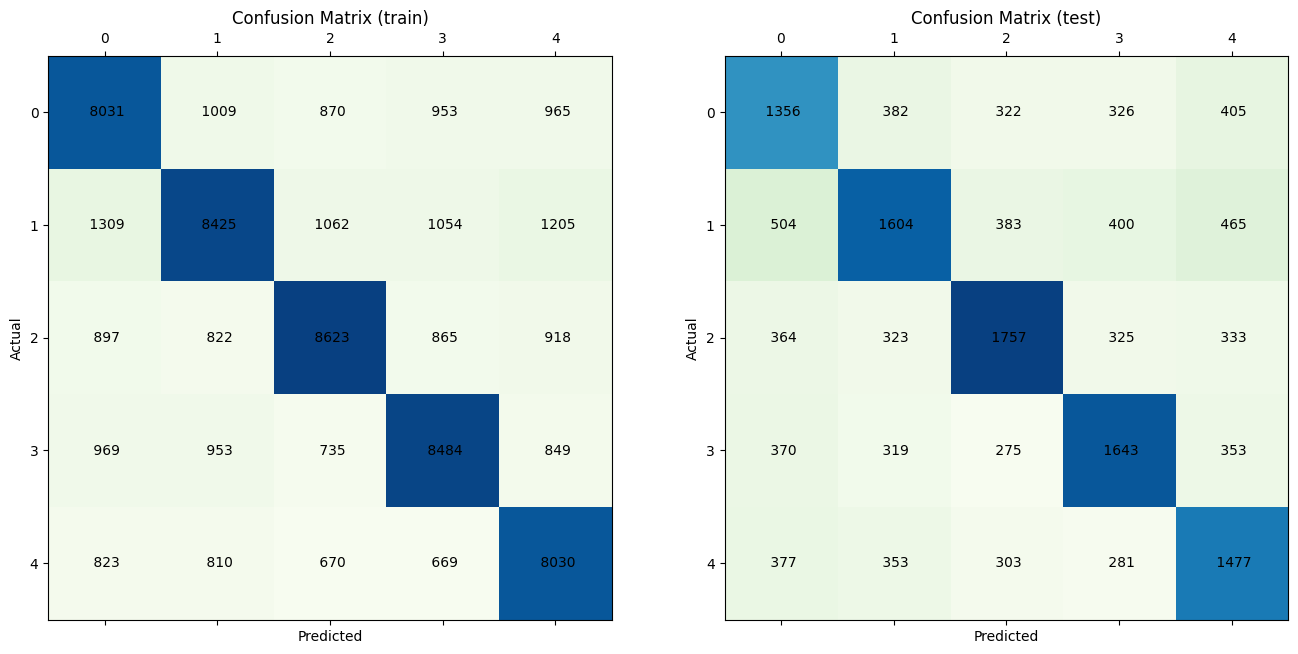

In [36]:
trees = random_forest(p3["X"], p3["Y"], n_trees=10, depth=15, impurity=gini)
metrics.print(predictForest(p3["X"], trees), p3["Y"], predictForest(p3["X_test"], trees), p3["Y_test"], visualize=True)

### Number of trees: 15, Number of features: 10

------------------ Train ---------------------
Classification Accuracy : 69.32%
Average F1 Score        : 0.69
Average Precision       : 0.69
Average Recall          : 0.69
------------------ Test ----------------------
Classification Accuracy : 52.25%
Average F1 Score        : 0.52
Average Precision       : 0.52
Average Recall          : 0.52
Confusion Matrix:
[[1356  504  364  370  377]
 [ 382 1604  323  319  353]
 [ 322  383 1757  275  303]
 [ 326  400  325 1643  281]
 [ 405  465  333  353 1477]]


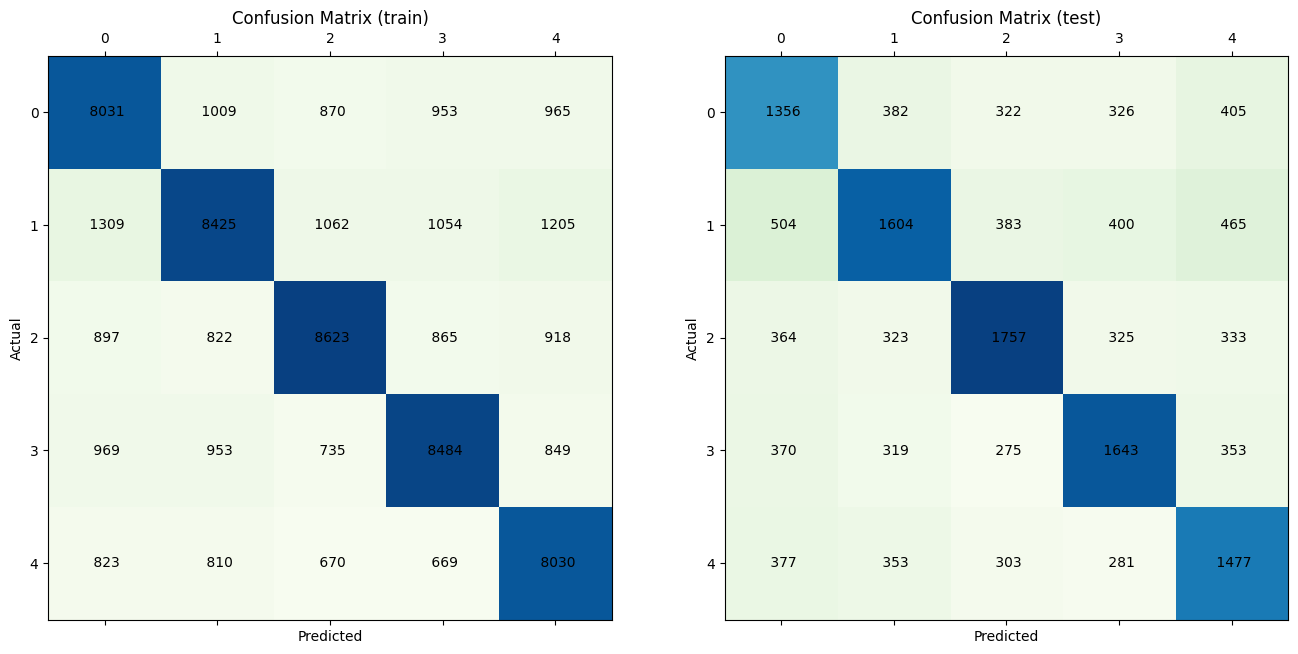

In [37]:
trees = random_forest(p3["X"], p3["Y"], n_trees=15, depth=15, impurity=gini)
metrics.print(predictForest(p3["X"], trees), p3["Y"], predictForest(p3["X_test"], trees), p3["Y_test"], visualize=True)

### Number of trees: 20, Number of features: 10

------------------ Train ---------------------
Classification Accuracy : 69.32%
Average F1 Score        : 0.69
Average Precision       : 0.69
Average Recall          : 0.69
------------------ Test ----------------------
Classification Accuracy : 52.25%
Average F1 Score        : 0.52
Average Precision       : 0.52
Average Recall          : 0.52
Confusion Matrix:
[[1356  504  364  370  377]
 [ 382 1604  323  319  353]
 [ 322  383 1757  275  303]
 [ 326  400  325 1643  281]
 [ 405  465  333  353 1477]]


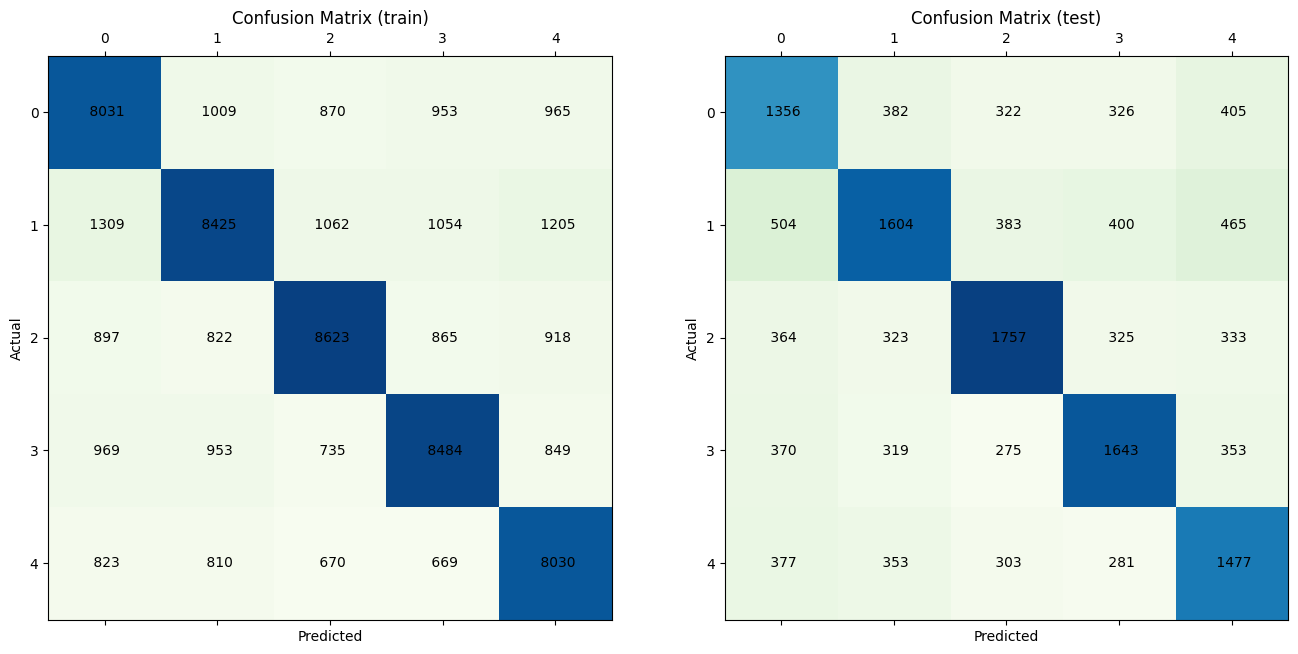

In [38]:
trees = random_forest(p3["X"], p3["Y"], n_trees=20, depth=15, impurity=gini)
metrics.print(predictForest(p3["X"], trees), p3["Y"], predictForest(p3["X_test"], trees), p3["Y_test"], visualize=True)

### Number of trees: 25, Number of features: 10

------------------ Train ---------------------
Classification Accuracy : 69.32%
Average F1 Score        : 0.69
Average Precision       : 0.69
Average Recall          : 0.69
------------------ Test ----------------------
Classification Accuracy : 52.25%
Average F1 Score        : 0.52
Average Precision       : 0.52
Average Recall          : 0.52
Confusion Matrix:
[[1356  504  364  370  377]
 [ 382 1604  323  319  353]
 [ 322  383 1757  275  303]
 [ 326  400  325 1643  281]
 [ 405  465  333  353 1477]]


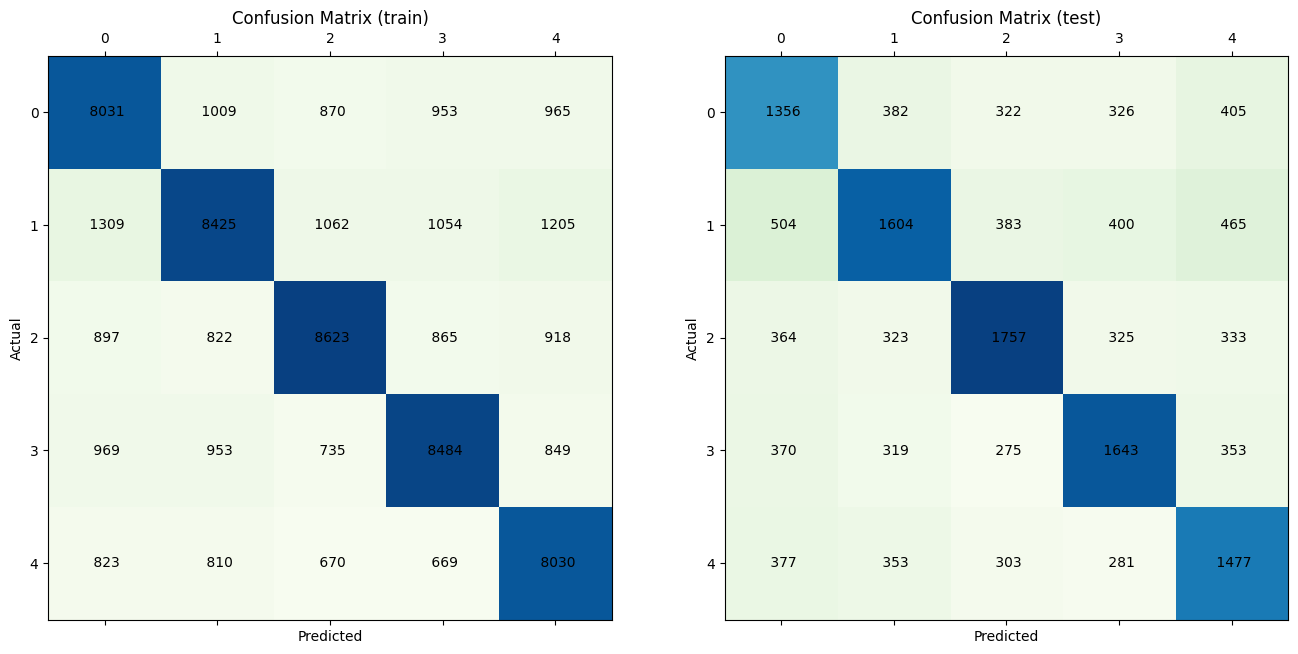

In [39]:
trees = random_forest(p3["X"], p3["Y"], n_trees=25, depth=15, impurity=gini)
metrics.print(predictForest(p3["X"], trees), p3["Y"], predictForest(p3["X_test"], trees), p3["Y_test"], visualize=True)

### Number of trees: 20, Number of features: 7

------------------ Train ---------------------
Classification Accuracy : 70.46%
Average F1 Score        : 0.71
Average Precision       : 0.71
Average Recall          : 0.70
------------------ Test ----------------------
Classification Accuracy : 52.99%
Average F1 Score        : 0.53
Average Precision       : 0.53
Average Recall          : 0.53
Confusion Matrix:
[[1491  495  327  336  322]
 [ 434 1685  300  276  286]
 [ 373  415 1763  251  238]
 [ 386  434  314 1620  221]
 [ 468  496  332  348 1389]]


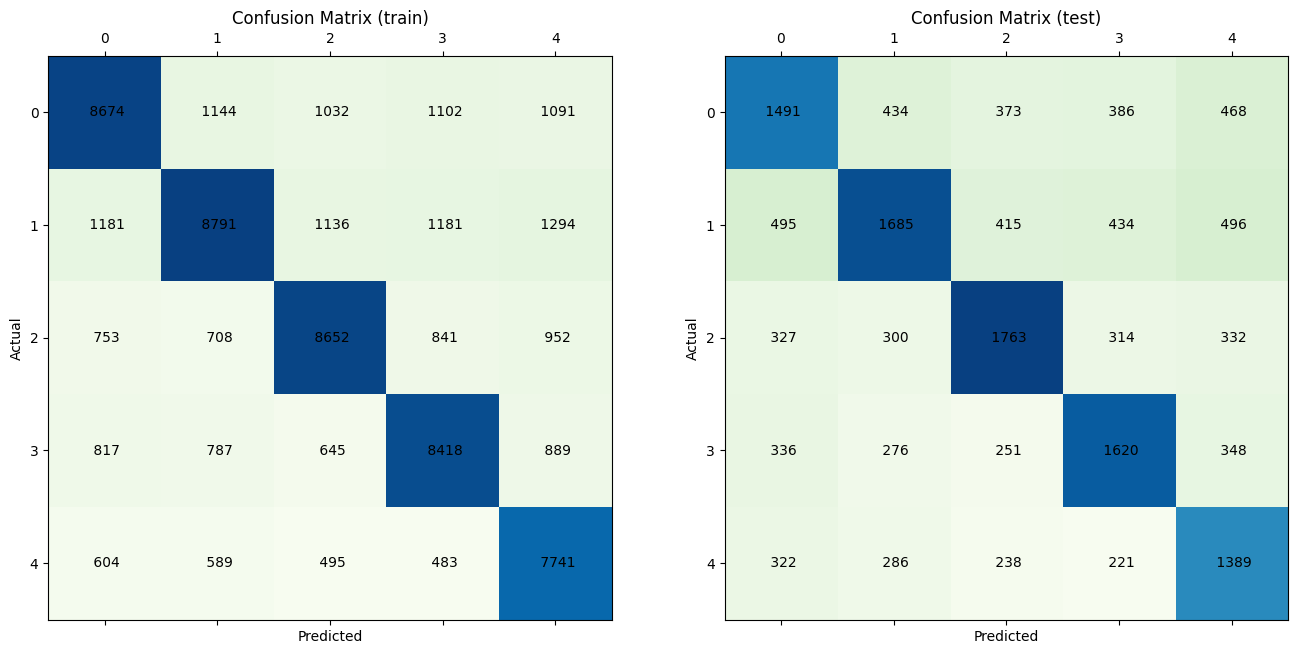

In [40]:
trees = random_forest(p3["X"], p3["Y"], n_trees=20, depth=15, impurity=gini, n_features=7)
metrics.print(predictForest(p3["X"], trees), p3["Y"], predictForest(p3["X_test"], trees), p3["Y_test"], visualize=True)

### Number of trees: 20, Number of features: 5

------------------ Train ---------------------
Classification Accuracy : 70.09%
Average F1 Score        : 0.70
Average Precision       : 0.70
Average Recall          : 0.70
------------------ Test ----------------------
Classification Accuracy : 53.02%
Average F1 Score        : 0.53
Average Precision       : 0.53
Average Recall          : 0.53
Confusion Matrix:
[[1448  492  333  347  351]
 [ 407 1648  300  302  324]
 [ 346  402 1764  258  270]
 [ 361  407  316 1641  250]
 [ 437  469  329  346 1452]]


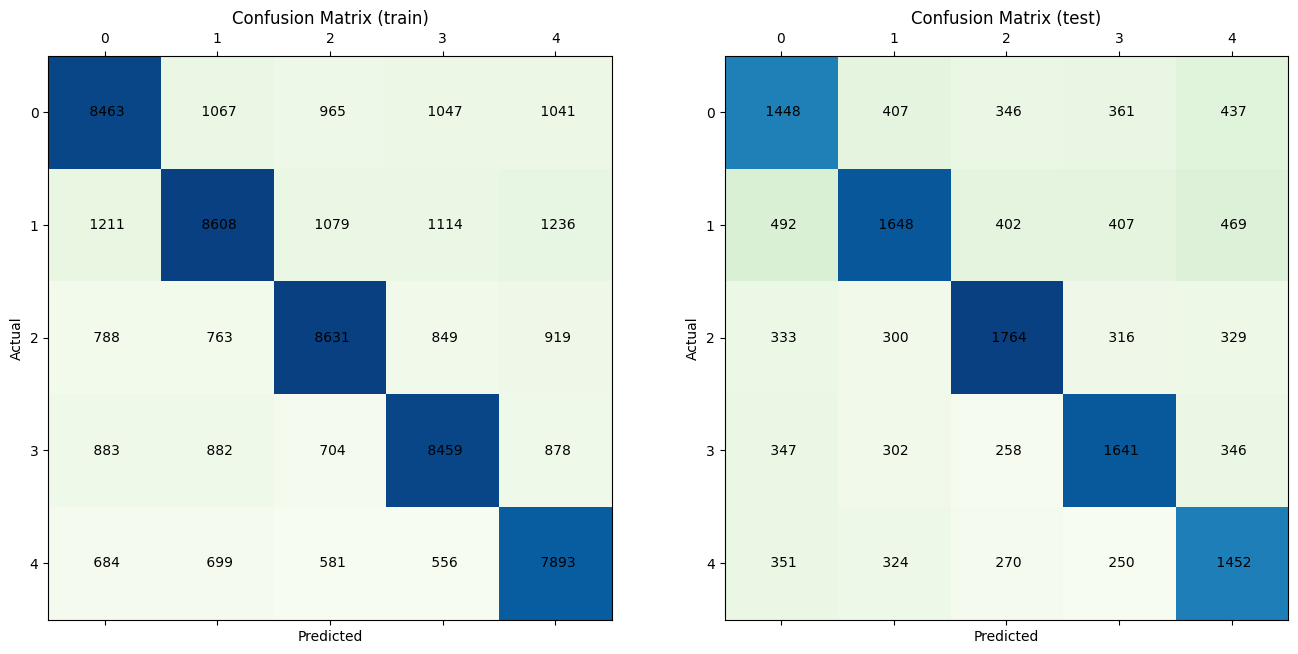

In [41]:
trees = random_forest(p3["X"], p3["Y"], n_trees=20, depth=15, impurity=gini, n_features=5)
metrics.print(predictForest(p3["X"], trees), p3["Y"], predictForest(p3["X_test"], trees), p3["Y_test"], visualize=True)

### Number of trees: 20, Number of features: 3

------------------ Train ---------------------
Classification Accuracy : 72.60%
Average F1 Score        : 0.73
Average Precision       : 0.73
Average Recall          : 0.73
------------------ Test ----------------------
Classification Accuracy : 55.61%
Average F1 Score        : 0.56
Average Precision       : 0.56
Average Recall          : 0.56
Confusion Matrix:
[[1527  450  279  353  362]
 [ 417 1718  247  287  312]
 [ 329  388 1789  265  269]
 [ 372  381  245 1722  255]
 [ 424  425  253  345 1586]]


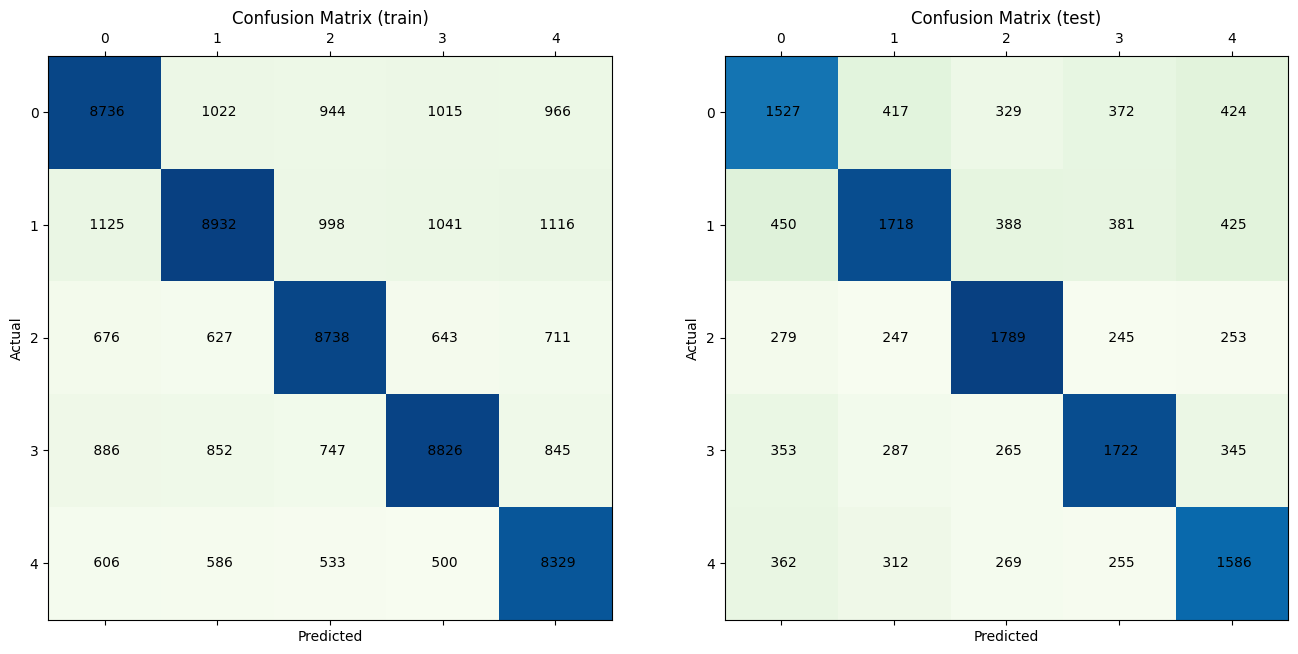

In [42]:
trees = random_forest(p3["X"], p3["Y"], n_trees=20, depth=15, impurity=gini, n_features=3)
metrics.print(predictForest(p3["X"], trees), p3["Y"], predictForest(p3["X_test"], trees), p3["Y_test"], visualize=True)

## Experiment on P4 data

### Number of trees: 10, Number of features: 64

------------------ Train ---------------------
Classification Accuracy : 97.97%
Average F1 Score        : 0.98
Average Precision       : 0.98
Average Recall          : 0.98
------------------ Test ----------------------
Classification Accuracy : 91.37%
Average F1 Score        : 0.91
Average Precision       : 0.91
Average Recall          : 0.91
Confusion Matrix:
[[1664   70    5   24    7    1    3   10   14    2]
 [  63 1663    5   18   18   16    2    4    7    4]
 [  12   12 1751    5    0   10    1    2    4    3]
 [  27   21   10 1549   25   29   18  104    8    9]
 [  11   16    4   41 1609   73    4    5   20   17]
 [   7   27   22   24   66 1624    3    6   21    0]
 [   1    5    2   20    0    1 1646  113    4    8]
 [   4    2    1   89    6    2  114 1578    2    2]
 [  23    9    2    3   16   15    3    0 1689   40]
 [   1   10    1   12   23   12   17    5   45 1674]]


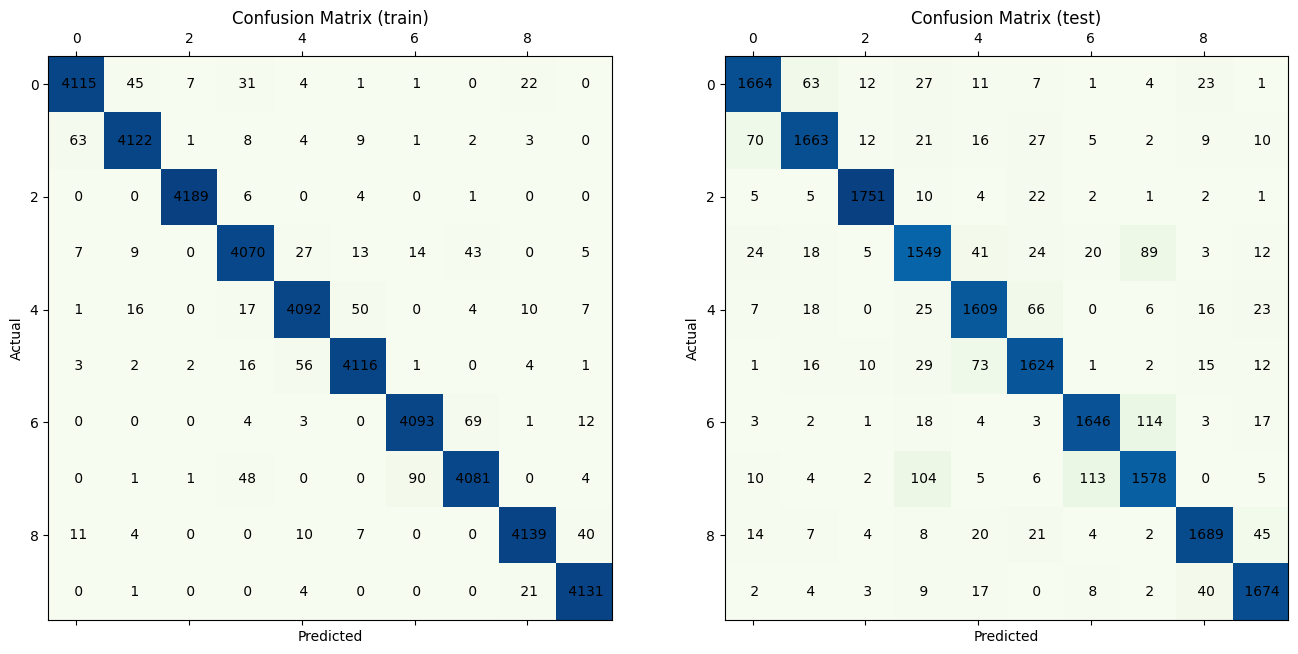

In [43]:
trees = random_forest(p4["X"], p4["Y"], n_trees=10, depth=15, impurity=gini)
metrics.print(predictForest(p4["X"], trees), p4["Y"], predictForest(p4["X_test"], trees), p4["Y_test"], visualize=True)

### Number of trees: 15, Number of features: 64

------------------ Train ---------------------
Classification Accuracy : 97.97%
Average F1 Score        : 0.98
Average Precision       : 0.98
Average Recall          : 0.98
------------------ Test ----------------------
Classification Accuracy : 91.37%
Average F1 Score        : 0.91
Average Precision       : 0.91
Average Recall          : 0.91
Confusion Matrix:
[[1664   70    5   24    7    1    3   10   14    2]
 [  63 1663    5   18   18   16    2    4    7    4]
 [  12   12 1751    5    0   10    1    2    4    3]
 [  27   21   10 1549   25   29   18  104    8    9]
 [  11   16    4   41 1609   73    4    5   20   17]
 [   7   27   22   24   66 1624    3    6   21    0]
 [   1    5    2   20    0    1 1646  113    4    8]
 [   4    2    1   89    6    2  114 1578    2    2]
 [  23    9    2    3   16   15    3    0 1689   40]
 [   1   10    1   12   23   12   17    5   45 1674]]


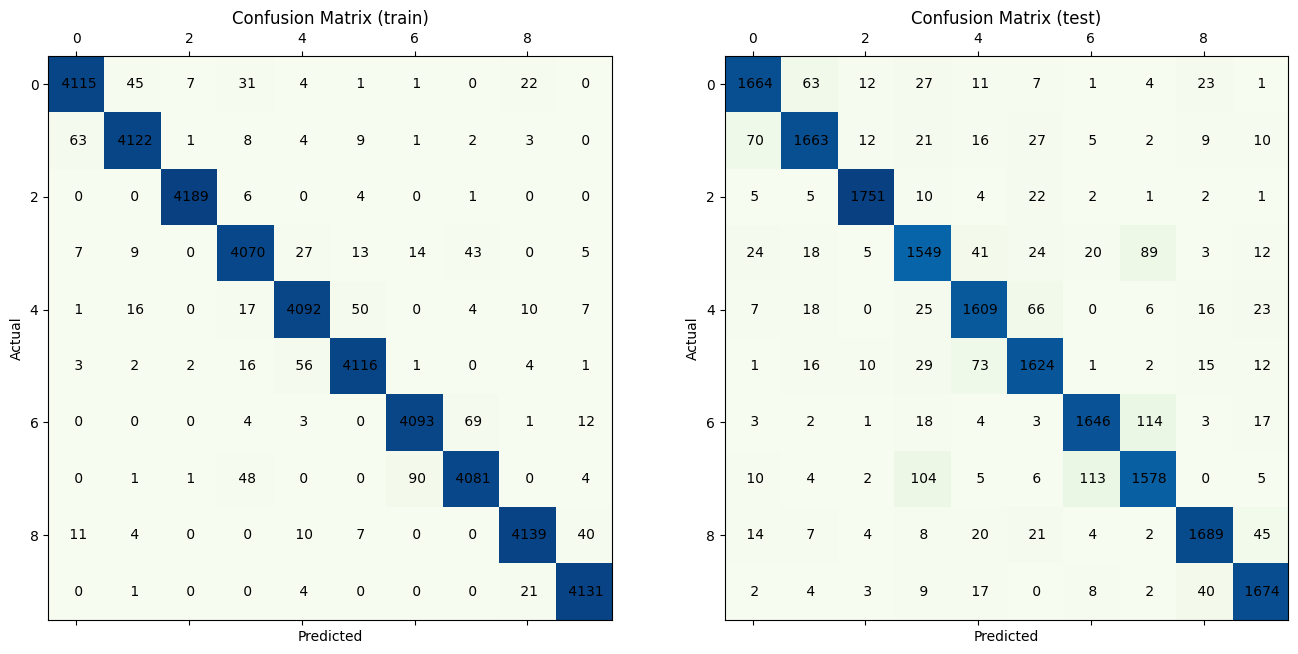

In [44]:
trees = random_forest(p4["X"], p4["Y"], n_trees=15, depth=15, impurity=gini)
metrics.print(predictForest(p4["X"], trees), p4["Y"], predictForest(p4["X_test"], trees), p4["Y_test"], visualize=True)

### Number of trees: 20, Number of features: 64

------------------ Train ---------------------
Classification Accuracy : 97.97%
Average F1 Score        : 0.98
Average Precision       : 0.98
Average Recall          : 0.98
------------------ Test ----------------------
Classification Accuracy : 91.37%
Average F1 Score        : 0.91
Average Precision       : 0.91
Average Recall          : 0.91
Confusion Matrix:
[[1664   70    5   24    7    1    3   10   14    2]
 [  63 1663    5   18   18   16    2    4    7    4]
 [  12   12 1751    5    0   10    1    2    4    3]
 [  27   21   10 1549   25   29   18  104    8    9]
 [  11   16    4   41 1609   73    4    5   20   17]
 [   7   27   22   24   66 1624    3    6   21    0]
 [   1    5    2   20    0    1 1646  113    4    8]
 [   4    2    1   89    6    2  114 1578    2    2]
 [  23    9    2    3   16   15    3    0 1689   40]
 [   1   10    1   12   23   12   17    5   45 1674]]


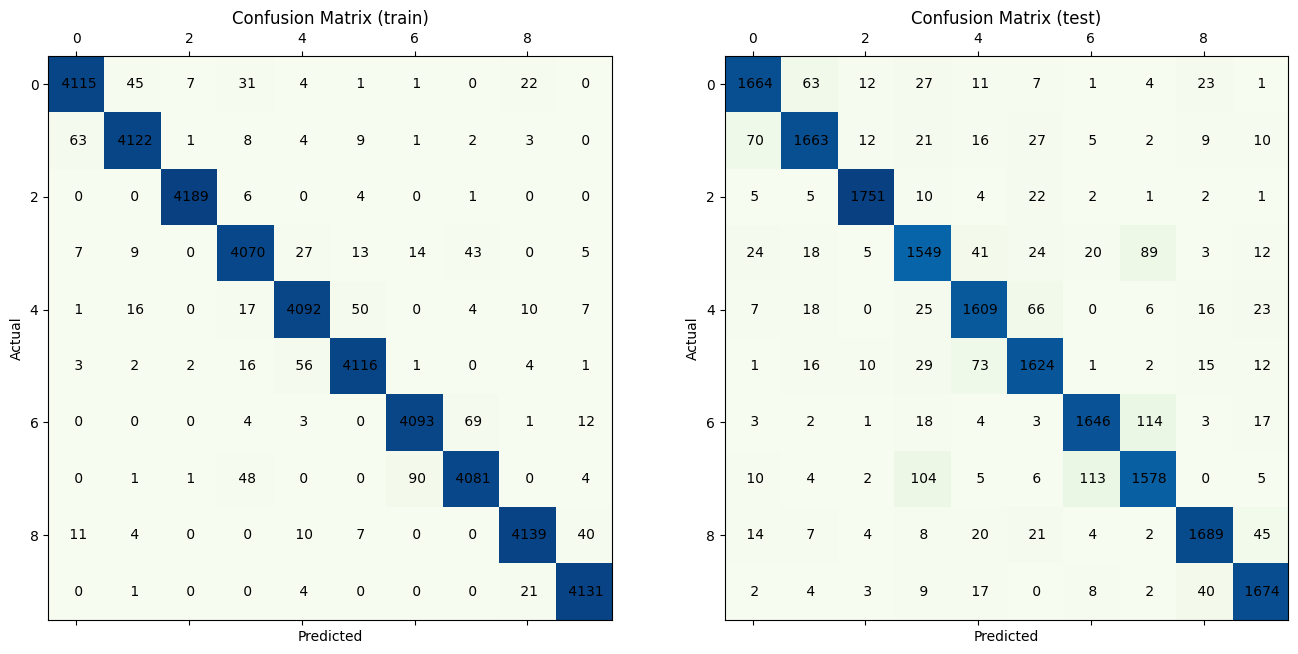

In [45]:
trees = random_forest(p4["X"], p4["Y"], n_trees=20, depth=15, impurity=gini)
metrics.print(predictForest(p4["X"], trees), p4["Y"], predictForest(p4["X_test"], trees), p4["Y_test"], visualize=True)

### Number of trees: 25, Number of features: 64

------------------ Train ---------------------
Classification Accuracy : 97.97%
Average F1 Score        : 0.98
Average Precision       : 0.98
Average Recall          : 0.98
------------------ Test ----------------------
Classification Accuracy : 91.37%
Average F1 Score        : 0.91
Average Precision       : 0.91
Average Recall          : 0.91
Confusion Matrix:
[[1664   70    5   24    7    1    3   10   14    2]
 [  63 1663    5   18   18   16    2    4    7    4]
 [  12   12 1751    5    0   10    1    2    4    3]
 [  27   21   10 1549   25   29   18  104    8    9]
 [  11   16    4   41 1609   73    4    5   20   17]
 [   7   27   22   24   66 1624    3    6   21    0]
 [   1    5    2   20    0    1 1646  113    4    8]
 [   4    2    1   89    6    2  114 1578    2    2]
 [  23    9    2    3   16   15    3    0 1689   40]
 [   1   10    1   12   23   12   17    5   45 1674]]


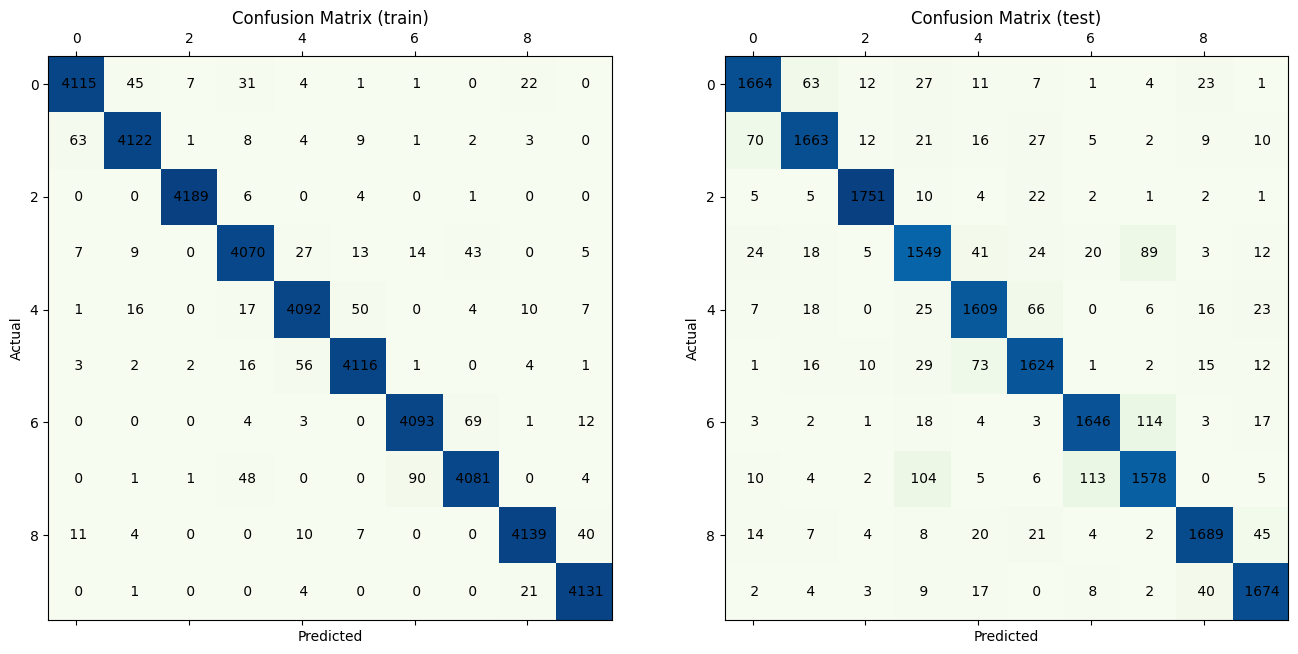

In [46]:
trees = random_forest(p4["X"], p4["Y"], n_trees=25, depth=15, impurity=gini)
metrics.print(predictForest(p4["X"], trees), p4["Y"], predictForest(p4["X_test"], trees), p4["Y_test"], visualize=True)

### Number of trees: 20, Number of features: 16

------------------ Train ---------------------
Classification Accuracy : 98.72%
Average F1 Score        : 0.99
Average Precision       : 0.99
Average Recall          : 0.99
------------------ Test ----------------------
Classification Accuracy : 94.66%
Average F1 Score        : 0.95
Average Precision       : 0.95
Average Recall          : 0.95
Confusion Matrix:
[[1713   51    2   15    2    2    1    6    6    2]
 [  29 1717    1   15   21    7    2    3    2    3]
 [  10    5 1773    4    1    6    0    0    1    0]
 [  26    8    7 1646   25   12    8   65    2    1]
 [   6   10    0   27 1695   38    1    1   11   11]
 [   4   18   11   13   40 1695    1    1   17    0]
 [   1    4    1   12    0    0 1709   66    1    6]
 [   2    4    0   68    4    1   77 1643    1    0]
 [  21    6    2    3    7    4    0    0 1730   27]
 [   1    3    0    8   13    0   19    3   35 1718]]


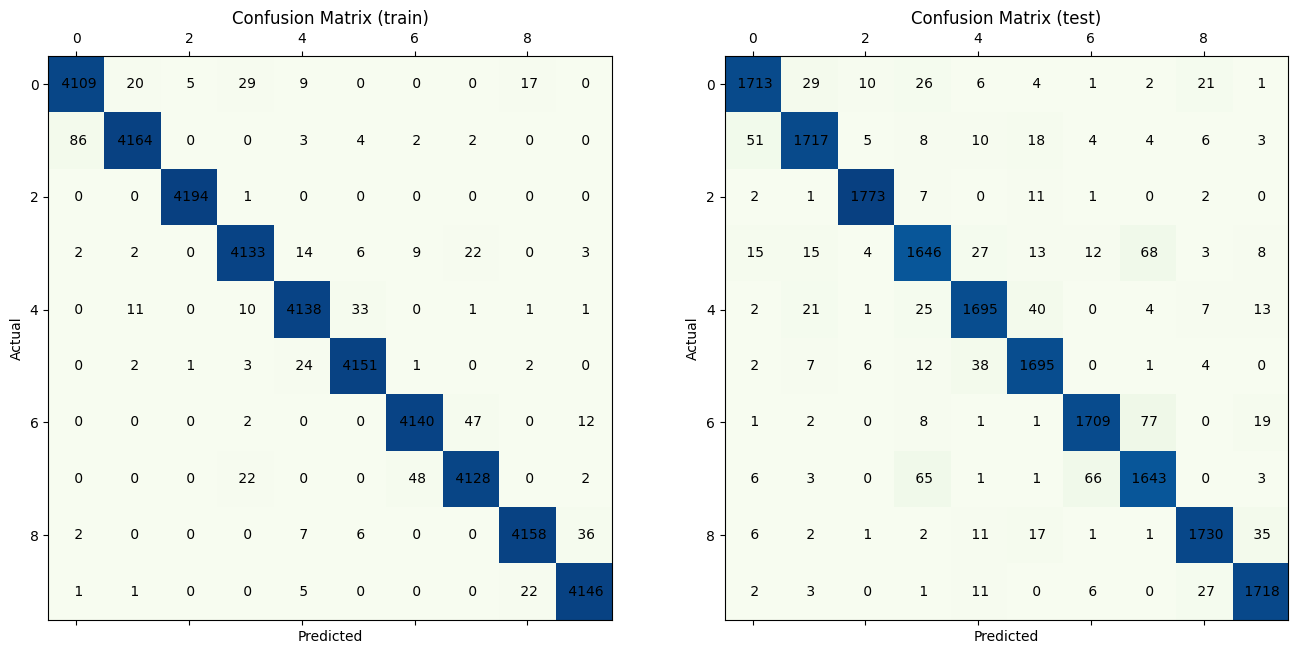

In [47]:
trees = random_forest(p4["X"], p4["Y"], n_trees=20, depth=15, impurity=gini, n_features=16)
metrics.print(predictForest(p4["X"], trees), p4["Y"], predictForest(p4["X_test"], trees), p4["Y_test"], visualize=True)

### Number of trees: 20, Number of features: 4

------------------ Train ---------------------
Classification Accuracy : 98.90%
Average F1 Score        : 0.99
Average Precision       : 0.99
Average Recall          : 0.99
------------------ Test ----------------------
Classification Accuracy : 95.79%
Average F1 Score        : 0.96
Average Precision       : 0.96
Average Recall          : 0.96
Confusion Matrix:
[[1720   52    1   17    2    2    1    1    3    1]
 [  26 1736    0   17   12    3    1    0    2    3]
 [   8    5 1777    5    3    2    0    0    0    0]
 [  25    5    4 1677   17    9    6   55    2    0]
 [   3   10    0   31 1709   29    1    0    8    9]
 [   1    7    3   13   41 1729    0    0    6    0]
 [   0    2    0   11    0    0 1735   48    0    4]
 [   2    3    0   48    6    1   61 1679    0    0]
 [  21    4    0    3    3    3    0    0 1746   20]
 [   3    1    0    6    5    0   17    8   26 1734]]


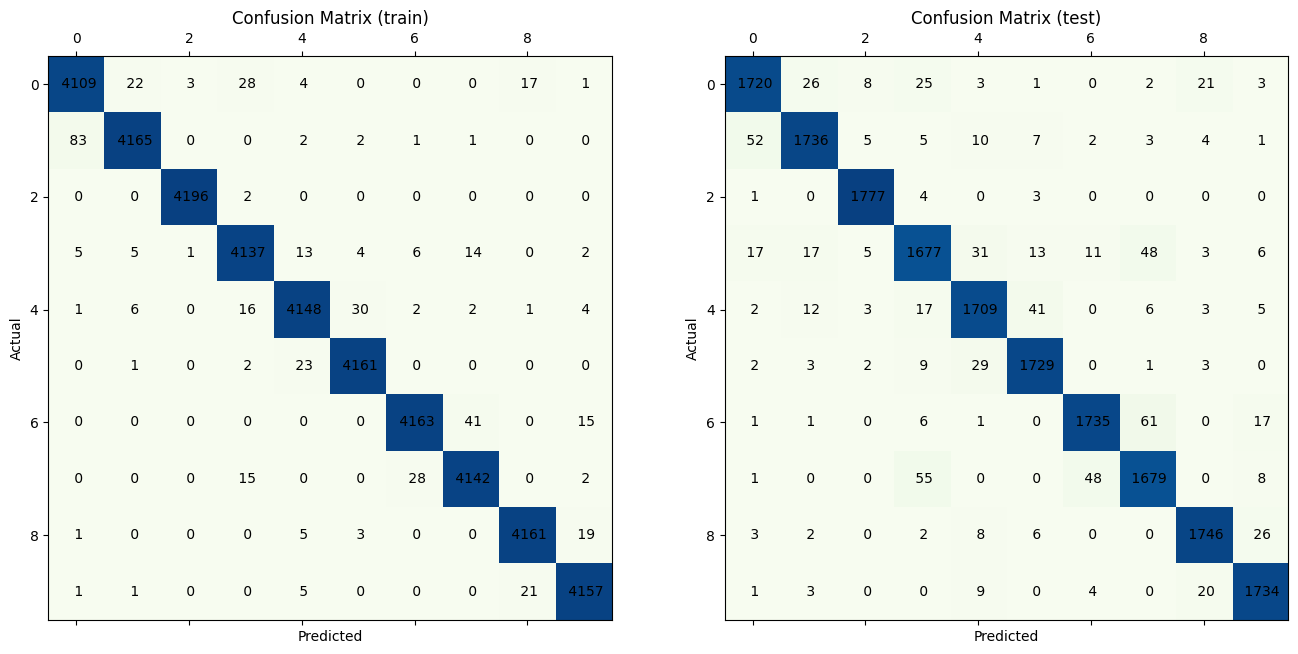

In [48]:
trees = random_forest(p4["X"], p4["Y"], n_trees=20, depth=15, impurity=gini, n_features=4)
metrics.print(predictForest(p4["X"], trees), p4["Y"], predictForest(p4["X_test"], trees), p4["Y_test"], visualize=True)

## Experiment on P5 data

### Number of trees: 10, Number of features: 10

------------------ Train ---------------------
Classification Accuracy : 96.56%
Average F1 Score        : 0.97
Average Precision       : 0.97
Average Recall          : 0.97
------------------ Test ----------------------
Classification Accuracy : 88.17%
Average F1 Score        : 0.88
Average Precision       : 0.88
Average Recall          : 0.88
Confusion Matrix:
[[2592  229   23   24    0    4    4   15   76   33]
 [ 190 2666    9   37   11    7    6   27   22   25]
 [   9    9 2858   11    0   53    4    8    9   39]
 [  35   41   61 2629   27   69   45   51   28   14]
 [   2    1    1   49 2700  132   10   32   11   62]
 [   9   11   24   39  120 2687    8   15   66   21]
 [   4    1    9   43    9    6 2600  313    2   13]
 [   5    3   70  152    9   12  407 2322    1   19]
 [  93   11    4    4   22   13    2    3 2808   40]
 [  62   50   20   17   66   37   32   69   59 2588]]


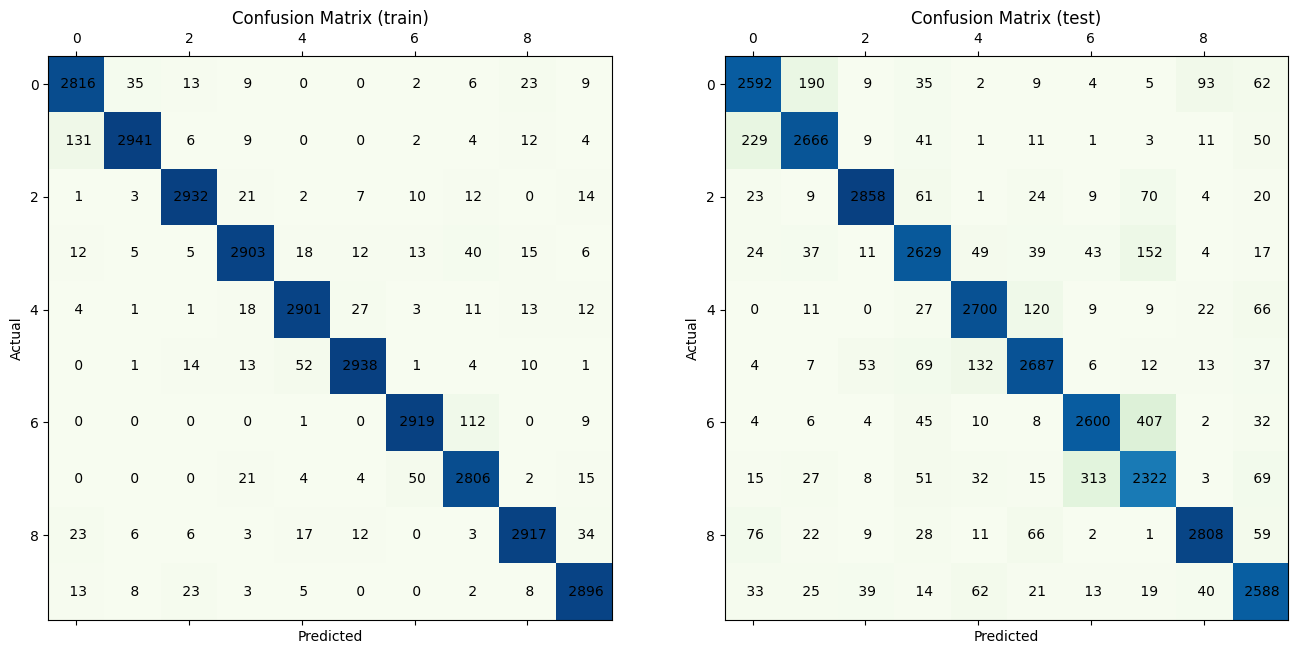

In [49]:
trees = random_forest(p5["X"], p5["Y"], n_trees=10, depth=15, impurity=gini)
metrics.print(predictForest(p5["X"], trees), p5["Y"], predictForest(p5["X_test"], trees), p5["Y_test"], visualize=True)

### Number of trees: 15, Number of features: 10

------------------ Train ---------------------
Classification Accuracy : 96.56%
Average F1 Score        : 0.97
Average Precision       : 0.97
Average Recall          : 0.97
------------------ Test ----------------------
Classification Accuracy : 88.17%
Average F1 Score        : 0.88
Average Precision       : 0.88
Average Recall          : 0.88
Confusion Matrix:
[[2592  229   23   24    0    4    4   15   76   33]
 [ 190 2666    9   37   11    7    6   27   22   25]
 [   9    9 2858   11    0   53    4    8    9   39]
 [  35   41   61 2629   27   69   45   51   28   14]
 [   2    1    1   49 2700  132   10   32   11   62]
 [   9   11   24   39  120 2687    8   15   66   21]
 [   4    1    9   43    9    6 2600  313    2   13]
 [   5    3   70  152    9   12  407 2322    1   19]
 [  93   11    4    4   22   13    2    3 2808   40]
 [  62   50   20   17   66   37   32   69   59 2588]]


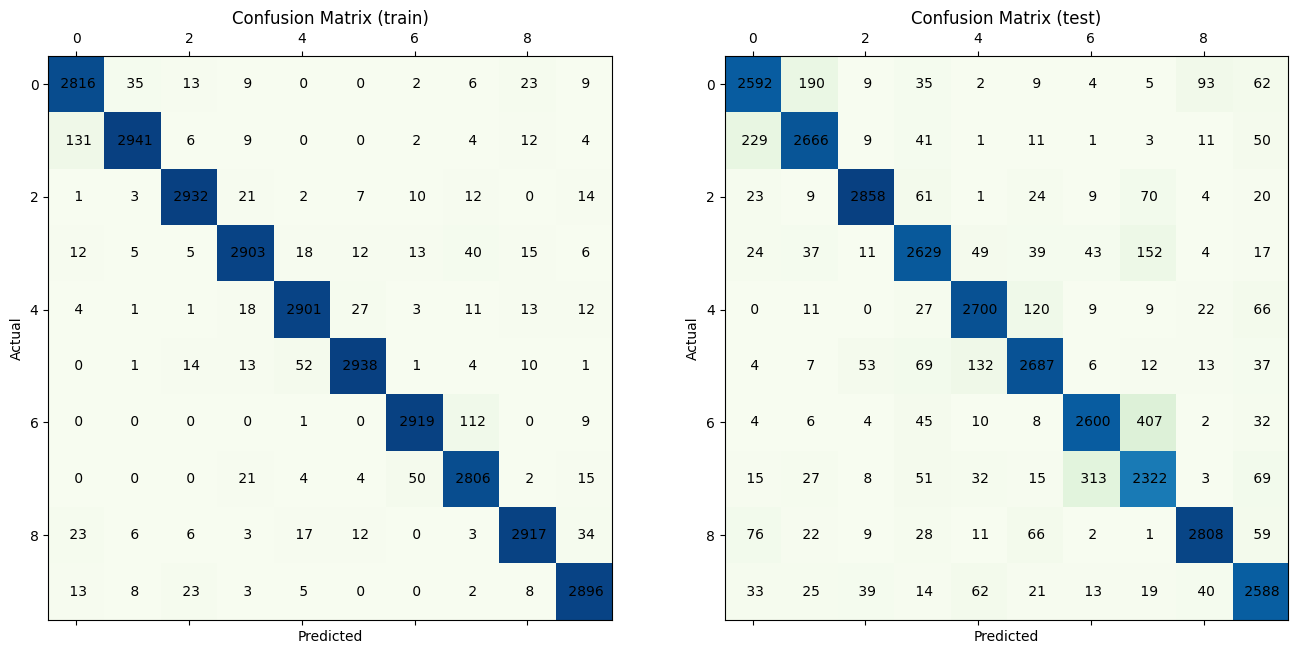

In [50]:
trees = random_forest(p5["X"], p5["Y"], n_trees=15, depth=15, impurity=gini)
metrics.print(predictForest(p5["X"], trees), p5["Y"], predictForest(p5["X_test"], trees), p5["Y_test"], visualize=True)

### Number of trees: 20, Number of features: 10

------------------ Train ---------------------
Classification Accuracy : 96.56%
Average F1 Score        : 0.97
Average Precision       : 0.97
Average Recall          : 0.97
------------------ Test ----------------------
Classification Accuracy : 88.17%
Average F1 Score        : 0.88
Average Precision       : 0.88
Average Recall          : 0.88
Confusion Matrix:
[[2592  229   23   24    0    4    4   15   76   33]
 [ 190 2666    9   37   11    7    6   27   22   25]
 [   9    9 2858   11    0   53    4    8    9   39]
 [  35   41   61 2629   27   69   45   51   28   14]
 [   2    1    1   49 2700  132   10   32   11   62]
 [   9   11   24   39  120 2687    8   15   66   21]
 [   4    1    9   43    9    6 2600  313    2   13]
 [   5    3   70  152    9   12  407 2322    1   19]
 [  93   11    4    4   22   13    2    3 2808   40]
 [  62   50   20   17   66   37   32   69   59 2588]]


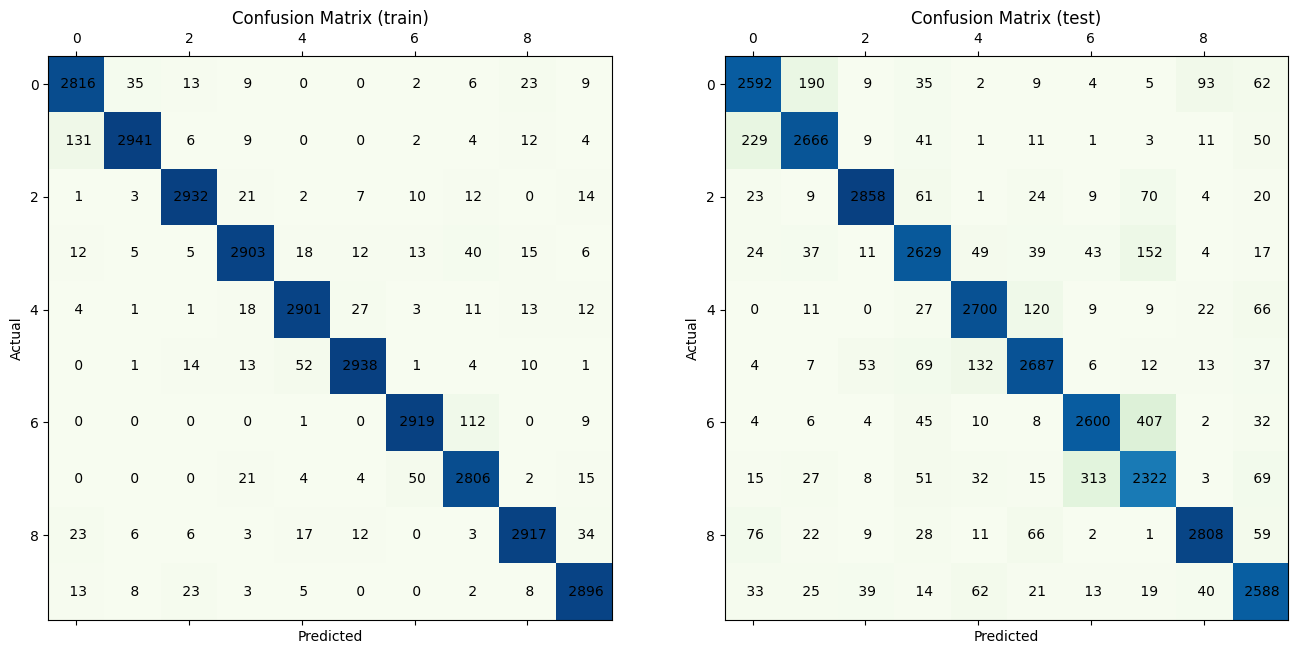

In [51]:
trees = random_forest(p5["X"], p5["Y"], n_trees=20, depth=15, impurity=gini)
metrics.print(predictForest(p5["X"], trees), p5["Y"], predictForest(p5["X_test"], trees), p5["Y_test"], visualize=True)

### Number of trees: 25, Number of features: 10

------------------ Train ---------------------
Classification Accuracy : 96.56%
Average F1 Score        : 0.97
Average Precision       : 0.97
Average Recall          : 0.97
------------------ Test ----------------------
Classification Accuracy : 88.17%
Average F1 Score        : 0.88
Average Precision       : 0.88
Average Recall          : 0.88
Confusion Matrix:
[[2592  229   23   24    0    4    4   15   76   33]
 [ 190 2666    9   37   11    7    6   27   22   25]
 [   9    9 2858   11    0   53    4    8    9   39]
 [  35   41   61 2629   27   69   45   51   28   14]
 [   2    1    1   49 2700  132   10   32   11   62]
 [   9   11   24   39  120 2687    8   15   66   21]
 [   4    1    9   43    9    6 2600  313    2   13]
 [   5    3   70  152    9   12  407 2322    1   19]
 [  93   11    4    4   22   13    2    3 2808   40]
 [  62   50   20   17   66   37   32   69   59 2588]]


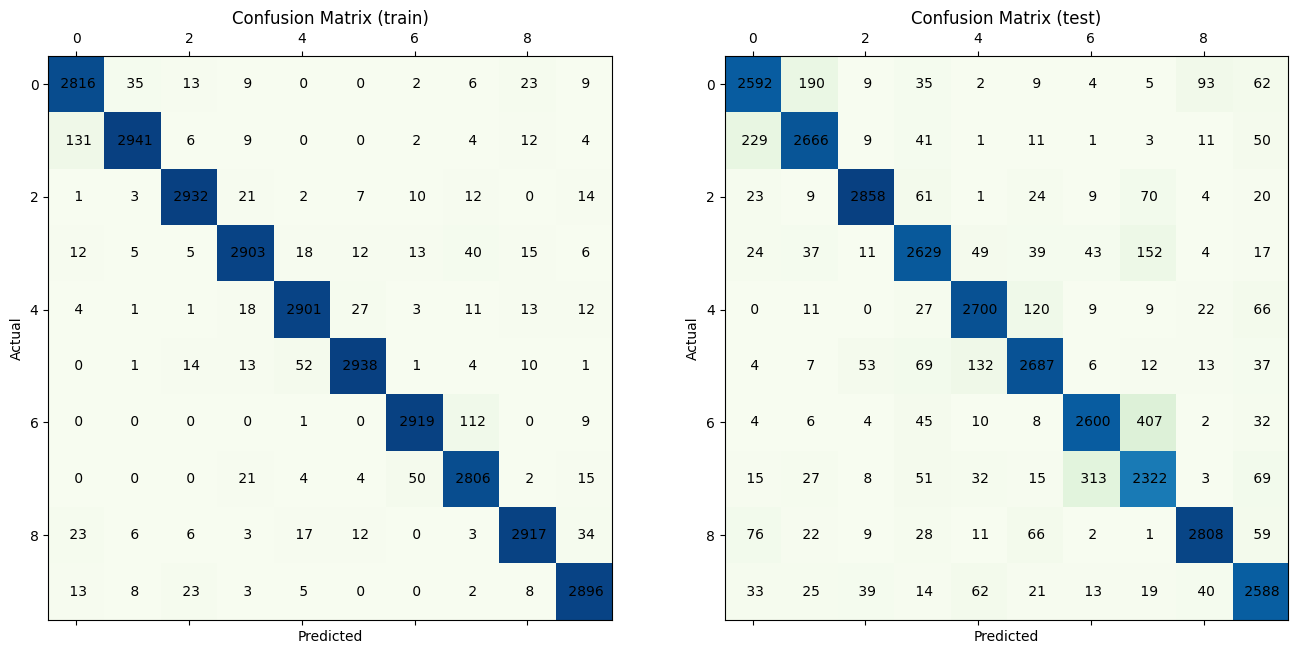

In [52]:
trees = random_forest(p5["X"], p5["Y"], n_trees=25, depth=15, impurity=gini)
metrics.print(predictForest(p5["X"], trees), p5["Y"], predictForest(p5["X_test"], trees), p5["Y_test"], visualize=True)

### Number of trees: 20, Number of features: 7

------------------ Train ---------------------
Classification Accuracy : 96.56%
Average F1 Score        : 0.97
Average Precision       : 0.97
Average Recall          : 0.97
------------------ Test ----------------------
Classification Accuracy : 88.17%
Average F1 Score        : 0.88
Average Precision       : 0.88
Average Recall          : 0.88
Confusion Matrix:
[[2592  229   23   24    0    4    4   15   76   33]
 [ 190 2666    9   37   11    7    6   27   22   25]
 [   9    9 2858   11    0   53    4    8    9   39]
 [  35   41   61 2629   27   69   45   51   28   14]
 [   2    1    1   49 2700  132   10   32   11   62]
 [   9   11   24   39  120 2687    8   15   66   21]
 [   4    1    9   43    9    6 2600  313    2   13]
 [   5    3   70  152    9   12  407 2322    1   19]
 [  93   11    4    4   22   13    2    3 2808   40]
 [  62   50   20   17   66   37   32   69   59 2588]]


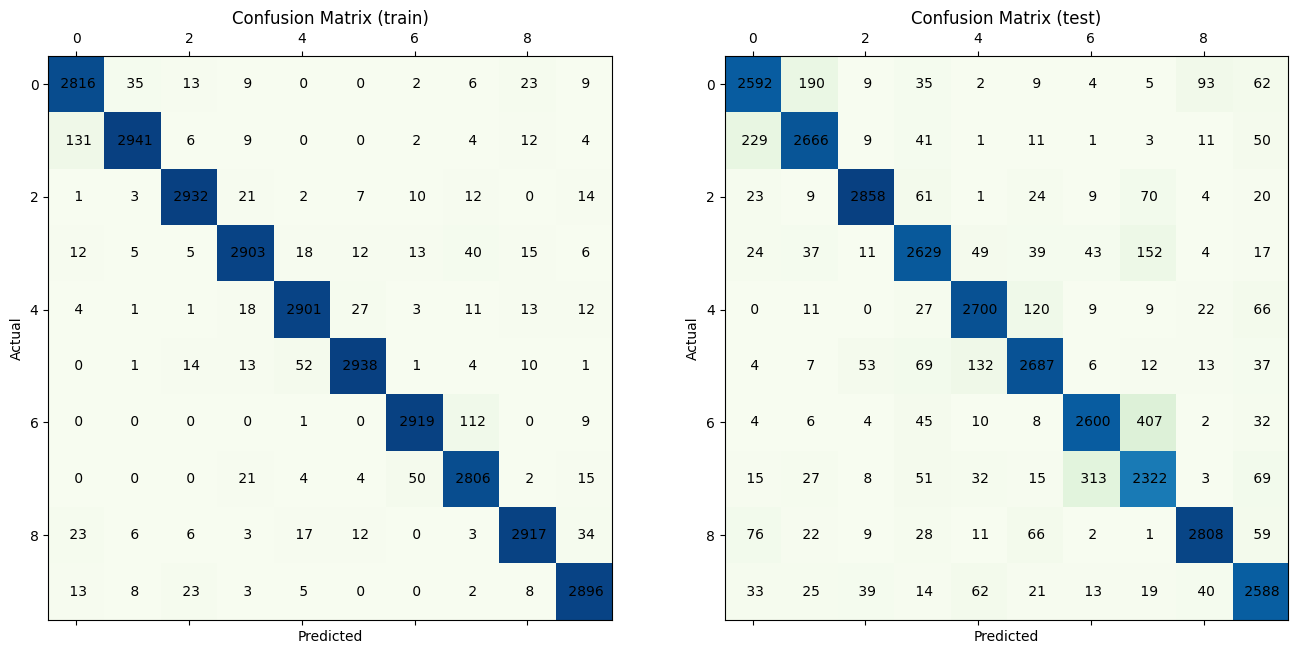

In [53]:
trees = random_forest(p5["X"], p5["Y"], n_trees=20, depth=15, impurity=gini, n_features=7)
metrics.print(predictForest(p5["X"], trees), p5["Y"], predictForest(p5["X_test"], trees), p5["Y_test"], visualize=True)

### Number of trees: 20, Number of features: 5

------------------ Train ---------------------
Classification Accuracy : 96.90%
Average F1 Score        : 0.97
Average Precision       : 0.97
Average Recall          : 0.97
------------------ Test ----------------------
Classification Accuracy : 89.02%
Average F1 Score        : 0.89
Average Precision       : 0.89
Average Recall          : 0.89
Confusion Matrix:
[[2672  188   16   22    0    4    3   13   59   23]
 [ 203 2665    8   35   10    7    5   25   18   24]
 [   9    9 2910    8    0   33    2    4    7   18]
 [  35   42   61 2664   19   64   33   47   23   12]
 [   2    1    1   53 2734  120    8   22    7   52]
 [   9   12   26   40  122 2691    7   14   61   18]
 [   4    1    9   44    9    6 2668  248    2    9]
 [   5    3   72  151    9   12  419 2312    1   16]
 [ 100   11    4    4   23   13    2    2 2806   35]
 [  63   50   20   17   66   37   32   70   60 2585]]


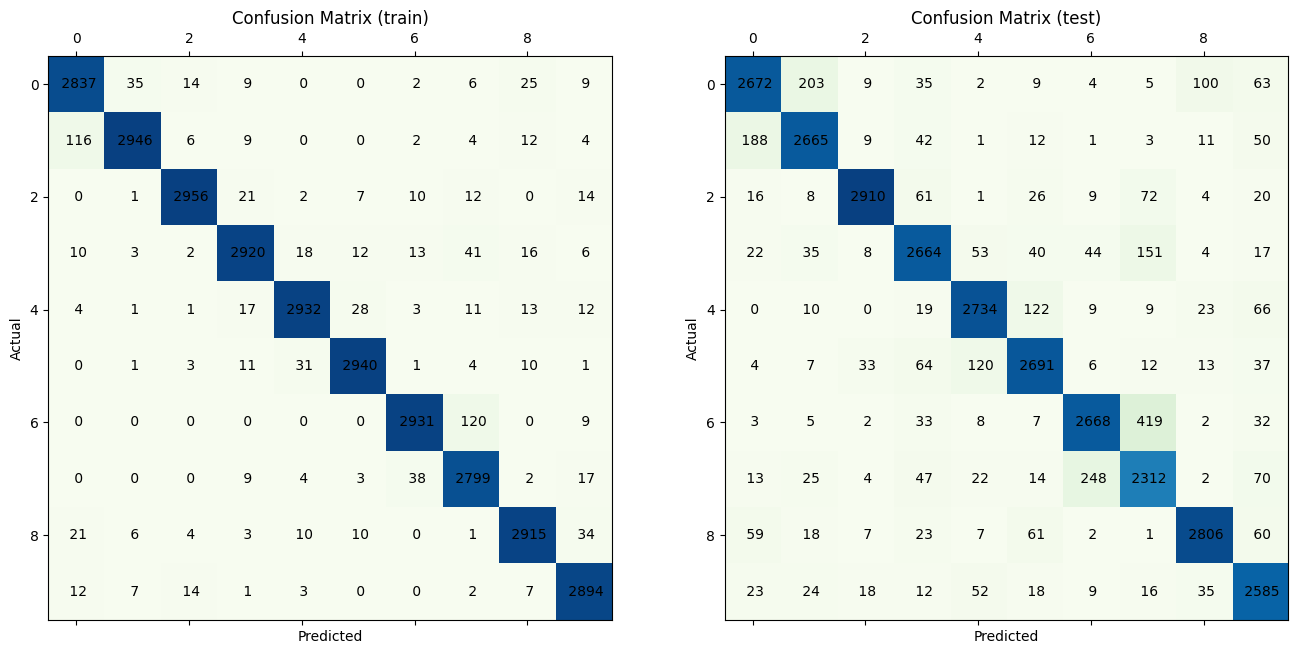

In [54]:
trees = random_forest(p5["X"], p5["Y"], n_trees=20, depth=15, impurity=gini, n_features=5)
metrics.print(predictForest(p5["X"], trees), p5["Y"], predictForest(p5["X_test"], trees), p5["Y_test"], visualize=True)

### Number of trees: 20, Number of features: 3

------------------ Train ---------------------
Classification Accuracy : 97.68%
Average F1 Score        : 0.98
Average Precision       : 0.98
Average Recall          : 0.98
------------------ Test ----------------------
Classification Accuracy : 91.78%
Average F1 Score        : 0.92
Average Precision       : 0.92
Average Recall          : 0.92
Confusion Matrix:
[[2727  177    5   13    0    1    2   10   49   16]
 [ 162 2737    3   34    7    1    4   11   18   23]
 [   5    3 2939    8    0   30    0    1    3   11]
 [  38   31   26 2772   11   40   22   37   19    4]
 [   3    0    0   49 2791  100    0   10    6   41]
 [   5   10   30   39  104 2743    5    2   55    7]
 [   5    2    3   32    1    3 2726  219    1    8]
 [   3    1   27  113    9    2  316 2523    1    5]
 [  83    7    2    2    6    8    1    0 2866   25]
 [  47   16    9   14   60   17   29   63   35 2710]]


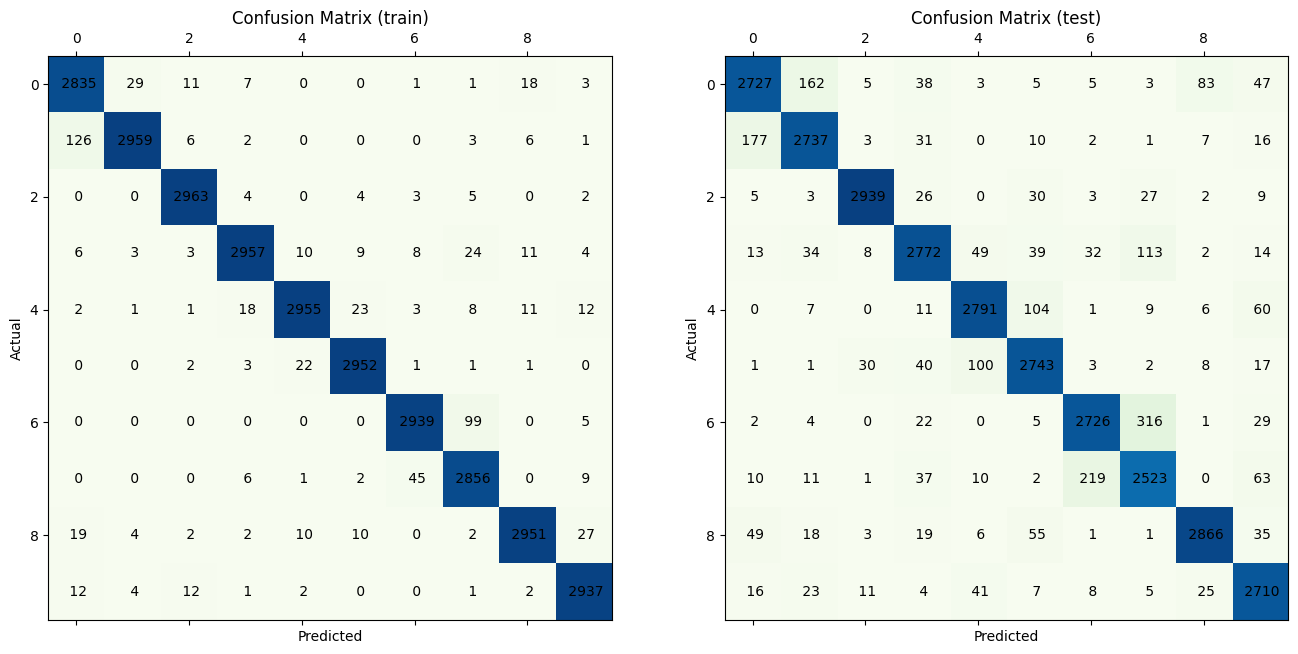

In [55]:
trees = random_forest(p5["X"], p5["Y"], n_trees=20, depth=15, impurity=gini, n_features=3)
metrics.print(predictForest(p5["X"], trees), p5["Y"], predictForest(p5["X_test"], trees), p5["Y_test"], visualize=True)

# Problem 3

Implement the Adaboost algorithm with at least 3 learners and one of them must be a Neural Network (MLP/CNN). 

Report the comparison between this and using only one classifier. 

Plot the convergence of train error as a function of the number of learners.

Data: `p3, p4, p5`

## Implementation

### MLP

In [131]:
class MLP:
    def __init__(self, sizes, activation='sigmoid', activation_last_layer='softmax', loss='ce', learning_rate=0.01, random_seed=42):
        np.random.seed(random_seed)
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.activation = activation
        self.activation_last_layer = activation_last_layer
        self.loss = loss
        self.learning_rate = learning_rate
        self.weights = [np.random.randn(sizes[i], sizes[i-1]) / np.sqrt(sizes[i-1]) for i in range(1, self.num_layers)]
        self.biases = [np.random.randn(sizes[i], 1) for i in range(1, self.num_layers)]

    def sigmoid(self, z):
        return 1.0 / (1.0 + np.exp(-z))

    def sigmoid_prime(self, z):
        return self.sigmoid(z) * (1 - self.sigmoid(z))

    def relu(self, z):
        return np.maximum(0, z)

    def relu_prime(self, z):
        return np.where(z > 0, 1, 0)
    
    def softmax(self, z):
        exp_z = np.exp(z - np.max(z))
        return exp_z / np.sum(exp_z, axis=0, keepdims=True)

    def softmax_prime(self, z):
        return self.softmax(z) * (1 - self.softmax(z))

    def cross_entropy_loss(self, y, y_pred):
        m = y.shape[1]
        cost = -1/m * np.sum(y * np.log(y_pred + 1e-8))
        return np.squeeze(cost)

    def cross_entropy_loss_prime(self, y, y_pred):
        return y_pred - y

    def squared_error_loss(self, y, y_pred):
        m = y.shape[1]
        cost = 1/(2*m) * np.sum((y_pred - y)**2)
        return np.squeeze(cost)

    def squared_error_loss_prime(self, y, y_pred):
        return y_pred - y

    def forward(self, X):
        a = X.T
        for i in range(self.num_layers-1):
            z = np.dot(self.weights[i], a) + self.biases[i]
            if i == self.num_layers-2:
                if self.activation_last_layer == 'softmax':
                    a = self.softmax(z)
            else:
                if self.activation == 'sigmoid':
                    a = self.sigmoid(z)
                elif self.activation == 'relu':
                    a = self.relu(z)
                    
        return a.T

    def backward(self, X, y):
        m = X.shape[0]
        a = [X.T]
        z_s = []
        for i in range(self.num_layers-1):
            z = np.dot(self.weights[i], a[-1]) + self.biases[i]
            z_s.append(z)
            if i == self.num_layers-2:
                if self.activation_last_layer == 'softmax':
                    a.append(self.softmax(z))
            else:
                if self.activation == 'sigmoid':
                    a.append(self.sigmoid(z))
                elif self.activation == 'relu':
                    a.append(self.relu(z))
                    
        if self.loss == 'ce':
            d_a = self.cross_entropy_loss_prime(y.T, a[-1])
        elif self.loss == 'mse':
            d_a = self.squared_error_loss_prime(y.T, a[-1])
            
        d_z = d_a
        d_weights = []
        d_biases = []
        for i in range(self.num_layers-2, -1, -1):
            d_weights.insert(0, np.dot(d_z, a[i].T) / m)
            d_biases.insert(0, np.sum(d_z, axis=1, keepdims=True) / m)
            if i > 0:
                if self.activation == 'sigmoid':
                    d_z = np.dot(self.weights[i].T, d_z) * self.sigmoid_prime(z_s[i-1])
                elif self.activation == 'relu':
                    d_z = np.dot(self.weights[i].T, d_z) * self.relu_prime(z_s[i-1])
                    
        return d_weights, d_biases
    
    def train(self, X_train, Y_train, X_val, Y_val, num_epochs, batch_size): 
        n_labels = len(np.unique(Y_train))
        y_train, y_val = [np.zeros((y.shape[0], n_labels)) for y in [Y_train, Y_val]]
        for i, j in enumerate(Y_train):
            y_train[i][int(j)] = 1
        for i, j in enumerate(Y_val):
            y_val[i][int(j)] = 1   
            
        train_losses = []
        val_losses = []
        train_accs = []
        val_accs = []
        
        for i in range(num_epochs):
            permutation = np.random.permutation(X_train.shape[0])
            X_train = X_train[permutation, :]
            y_train = y_train[permutation]
            
            for j in range(0, X_train.shape[0], batch_size):
                
                X_batch = X_train[j : j + batch_size, :]
                y_batch = y_train[j : j + batch_size]
                
                d_weights, d_biases = self.backward(X_batch, y_batch)
                
                for k in range(len(self.weights)):
                    self.weights[k] -= self.learning_rate * d_weights[k]
                    self.biases[k] -= self.learning_rate * d_biases[k]
                    
            y_pred_train = self.forward(X_train)
            y_pred_val = self.forward(X_val)
            
            if self.loss == 'ce':
                train_loss = self.cross_entropy_loss(y_train, y_pred_train)
                val_loss = self.cross_entropy_loss(y_val, y_pred_val)
            elif self.loss == 'mse':
                train_loss = self.squared_error_loss(y_train, y_pred_train)
                val_loss = self.squared_error_loss(y_val, y_pred_val)
                
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            
            acc_params_train = [np.argmax(y_train, axis=1), np.argmax(y_pred_train, axis=1)]
            acc_params_val = [np.argmax(y_val, axis=1), np.argmax(y_pred_val, axis=1)]
            
            train_acc = metrics.accuracy(*acc_params_train)
            val_acc = metrics.accuracy(*acc_params_val)
            
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            
            # train_f1 = metrics.f1Score(metrics.confusionMatrix(*acc_params_train, n_labels))
            # val_f1 = metrics.f1Score(metrics.confusionMatrix(*acc_params_val, n_labels))
            
            # print(f"Epoch {i+1}: \t  train_loss = {train_loss:.2f}  \tval_loss = {val_loss:.2f} \t  train_acc = {train_acc:.2f}  \t val_acc = {val_acc:.2f}")
        return train_losses, val_losses, train_accs, val_accs

### Adaboost

In [144]:
def mlpForAdaboost(X, y, hidden_layers=[32, 16]):
    n_labels = len(np.unique(y))

    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    s = int(0.7 * X.shape[0])
    xtrain, xval = X[indices[:s]], X[indices[s:]]
    ytrain, yval = y[indices[:s]], y[indices[s:]]

    layers = [xtrain.shape[1], *hidden_layers, n_labels]
    mlp = MLP(layers, 'sigmoid', 'softmax','ce', learning_rate = 0.1)
    mlp.train(xtrain, ytrain, xval, yval, num_epochs = 50 , batch_size = 256)
    return mlp

# adaboost with numpy
def adaboost(X, y, num_DT_classifiers, max_depth=10, mlp_hidden_layers=[7]):
    N = X.shape[0]
    w = np.ones(N) / N
    classifiers = []
    alphas = []
    errors = []

    # mlp as first classifier
    mlp = mlpForAdaboost(X, y, mlp_hidden_layers)
    y_pred = np.argmax(mlp.forward(X), axis=1)
    error = np.sum(w * (y_pred != y))
    alpha = np.log((1 - error) / error) / 2
    w = w * np.exp(-alpha * y * y_pred)
    w = w / np.sum(w)
    classifiers.append(mlp)
    alphas.append(alpha)
    errors.append(error)

    # decision trees are remaining classifiers
    for _ in range(num_DT_classifiers):
        tree = buildTree(X, y, gini, max_depth=max_depth)
        y_pred = predictAll(X, tree)
        error = np.sum(w * (y_pred != y))
        alpha = np.log((1 - error) / error) / 2
        w = w * np.exp(-alpha * np.array([1 if y_pred[i] == y[i] else -1 for i in range(N)]))
        w = w / np.sum(w)
        classifiers.append(tree)
        alphas.append(alpha)
        errors.append(error)

    return classifiers, alphas, errors

def predictAdaboost(X, classifiers, alphas, n_labels):
    likelihoods = np.zeros((X.shape[0], n_labels))
    y_pred = np.argmax(classifiers[0].forward(X), axis=1)
    for i in range(X.shape[0]):
        likelihoods[i][y_pred[i]] += alphas[0]
    for i in range(1, len(classifiers) - 1):
        y_pred = predictAll(X, classifiers[i])
        for j in range(X.shape[0]):
            likelihoods[j][y_pred[j]] += alphas[i]
    return np.argmax(likelihoods, axis=1)


## Experiment on P3 Data

------------------ Train ---------------------
Classification Accuracy : 57.39%
Average F1 Score        : 0.57
Average Precision       : 0.58
Average Recall          : 0.57
------------------ Test ----------------------
Classification Accuracy : 57.39%
Average F1 Score        : 0.57
Average Precision       : 0.58
Average Recall          : 0.57
Confusion Matrix:
[[1611  378  228  381  373]
 [ 416 1679  247  297  342]
 [ 411  303 1788  257  281]
 [ 384  332  207 1778  274]
 [ 417  340  188  336 1752]]


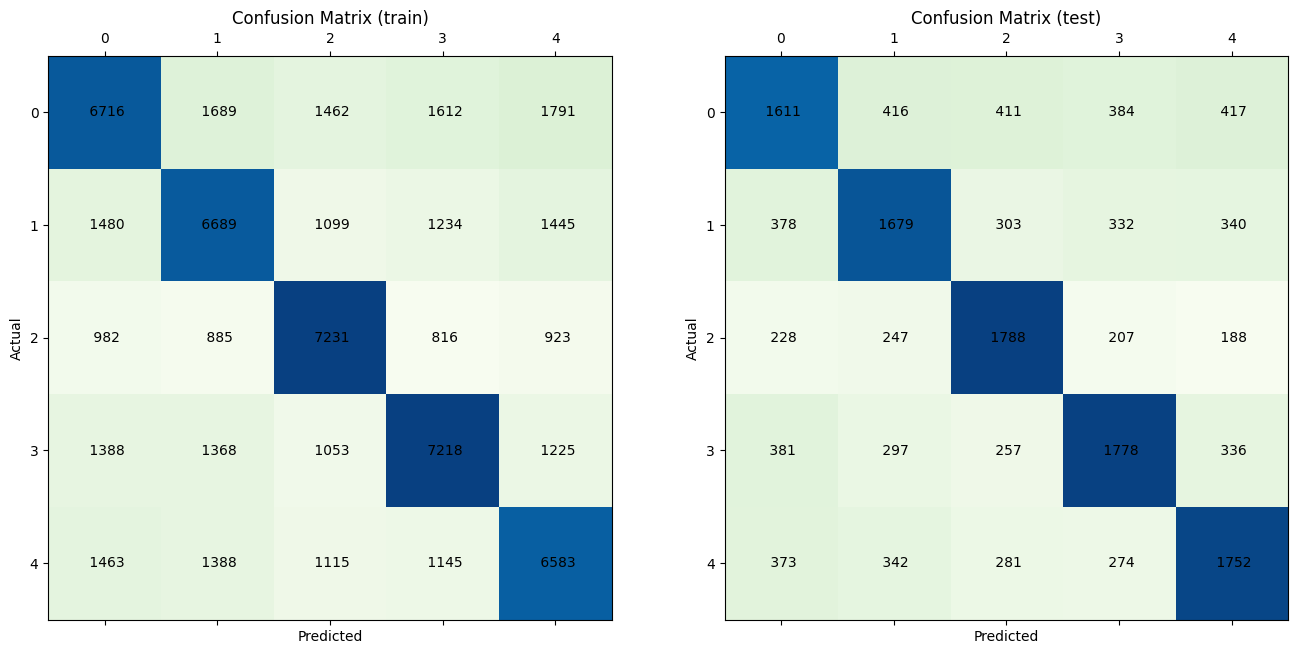

In [145]:
n_labels = len(np.unique(p3['Y']))
c, a, e = adaboost(p3['X'], p3['Y'], 10, 4)
metrics.print(predictAdaboost(p3['X'], c, a, n_labels), p3['Y'], predictAdaboost(p3['X_test'], c, a, n_labels), p3['Y_test'], visualize=True)


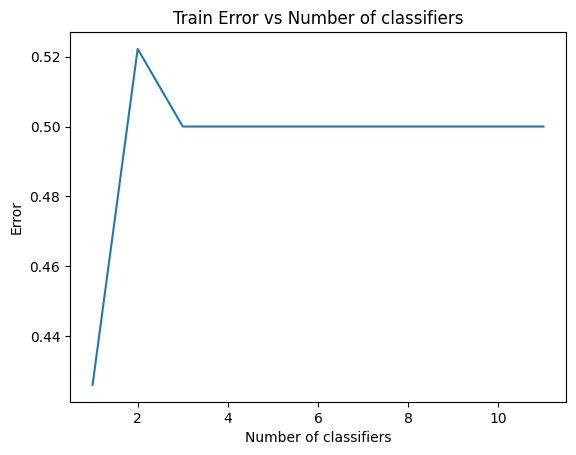

In [146]:
plt.plot(np.arange(1, len(e) + 1), e)
plt.xlabel('Number of classifiers')
plt.ylabel('Error')
plt.title('Train Error vs Number of classifiers')
plt.show()

## Experiment on P4 Data

------------------ Train ---------------------
Classification Accuracy : 97.97%
Average F1 Score        : 0.98
Average Precision       : 0.98
Average Recall          : 0.98
------------------ Test ----------------------
Classification Accuracy : 91.37%
Average F1 Score        : 0.91
Average Precision       : 0.91
Average Recall          : 0.91
Confusion Matrix:
[[1664   70    5   24    7    1    3   10   14    2]
 [  63 1663    5   18   18   16    2    4    7    4]
 [  12   12 1751    5    0   10    1    2    4    3]
 [  27   21   10 1549   25   29   18  104    8    9]
 [  11   16    4   41 1609   73    4    5   20   17]
 [   7   27   22   24   66 1624    3    6   21    0]
 [   1    5    2   20    0    1 1646  113    4    8]
 [   4    2    1   89    6    2  114 1578    2    2]
 [  23    9    2    3   16   15    3    0 1689   40]
 [   1   10    1   12   23   12   17    5   45 1674]]


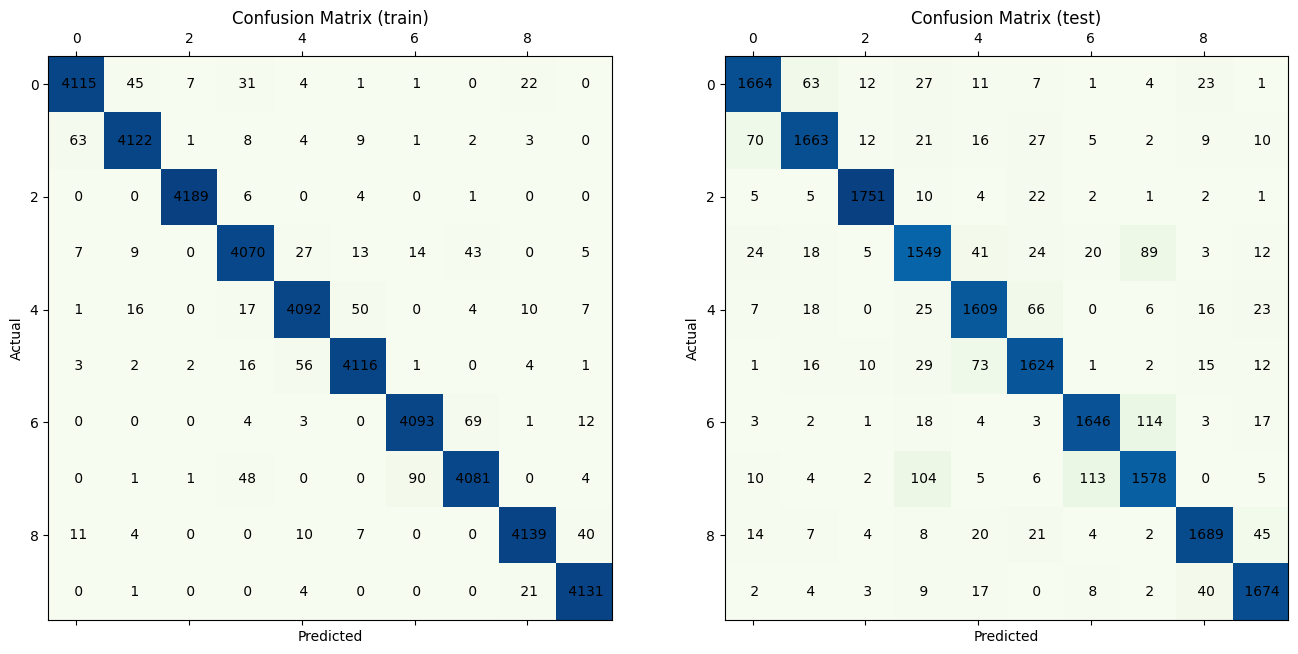

In [158]:
n_labels = len(np.unique(p4['Y']))
c, a, e = adaboost(p4['X'], p4['Y'], 10, 15, [32])
metrics.print(predictAdaboost(p4['X'], c, a, n_labels), p4['Y'], predictAdaboost(p4['X_test'], c, a, n_labels), p4['Y_test'], visualize=True)

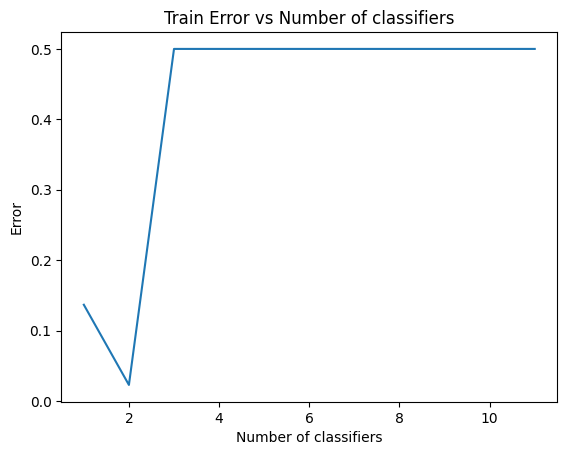

In [159]:
plt.plot(np.arange(1, len(e) + 1), e)
plt.xlabel('Number of classifiers')
plt.ylabel('Error')
plt.title('Train Error vs Number of classifiers')
plt.show()

## Experiment on P5 Data

/tmp/ipykernel_1127995/3404530601.py:14: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))


------------------ Train ---------------------
Classification Accuracy : 82.00%
Average F1 Score        : 0.82
Average Precision       : 0.83
Average Recall          : 0.82
------------------ Test ----------------------
Classification Accuracy : 85.65%
Average F1 Score        : 0.86
Average Precision       : 0.86
Average Recall          : 0.86
Confusion Matrix:
[[2428  398   14   21   14    0    0   48   39   38]
 [  38 2772   16   37    6   37    1   23   26   44]
 [  80    8 2650   38    1  220    0    0    1    2]
 [  21   20   12 2249   37  358   67  199   36    1]
 [   0    0    0   30 2692  122    2    4  116   34]
 [   2   22   68   48   53 2713   12    2   74    6]
 [   2    1    2   41   10   33 2181  721    8    1]
 [  14    0    0  245   10   40   73 2611    6    1]
 [  89   15   17    9   19    3    1    2 2802   43]
 [  42    9    5   11  125   47    5   48  110 2598]]


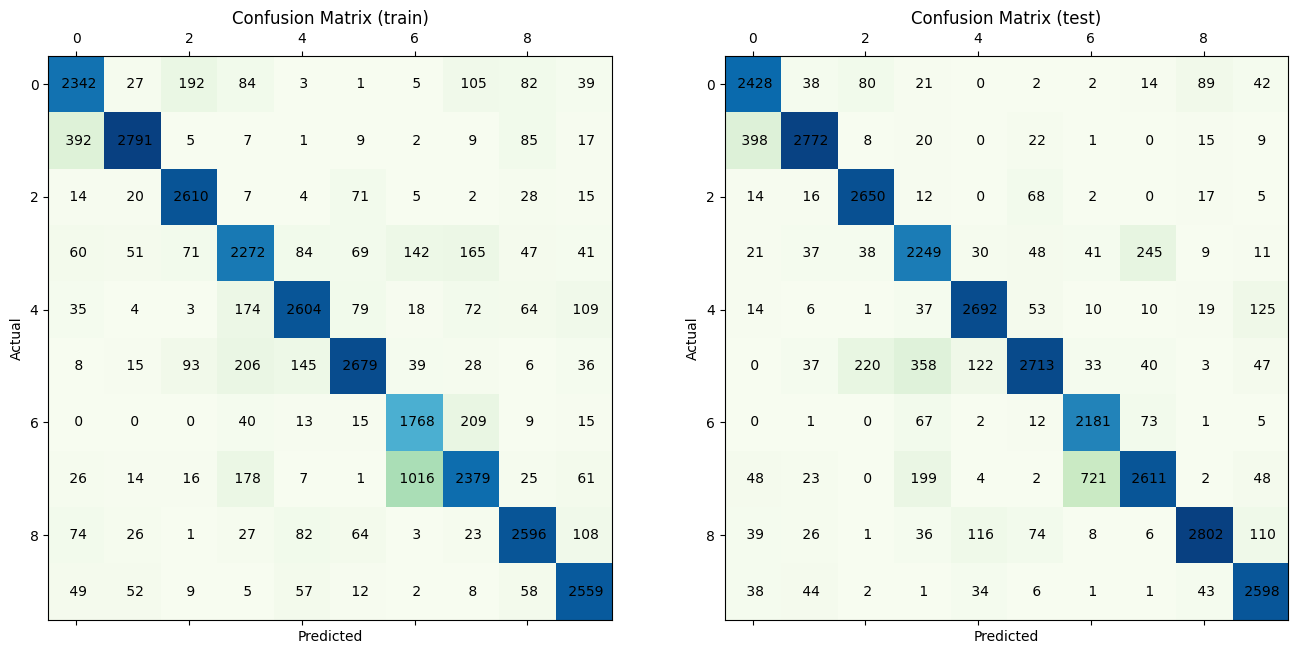

In [150]:
n_labels = len(np.unique(p5['Y']))
c, a, e = adaboost(p5['X'], p5['Y'], 10, 4)
metrics.print(predictAdaboost(p5['X'], c, a, n_labels), p5['Y'], predictAdaboost(p5['X_test'], c, a, n_labels), p5['Y_test'], visualize=True)

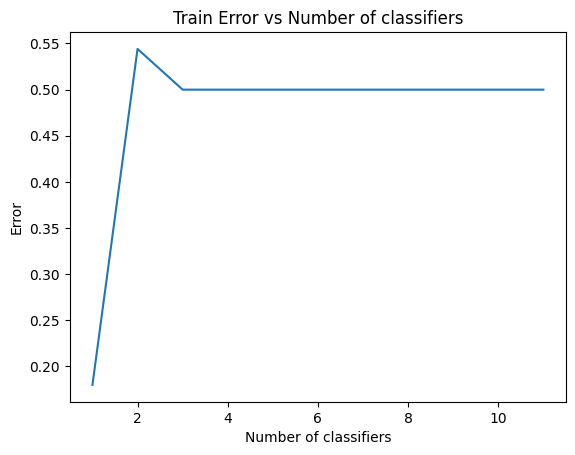

In [151]:
plt.plot(np.arange(1, len(e) + 1), e)
plt.xlabel('Number of classifiers')
plt.ylabel('Error')
plt.title('Train Error vs Number of classifiers')
plt.show()

# Problem 4

Consider the KMNIST data and implement 

    (a) GMM-based clustering, 
    
    (b) K means clustering.
    
Evaluate and compare the Normalized Mutual Information for both algorithms. 

Experiment with different number of cluster sizes and plot the t-sne plots for all cases.

Data: `p4`

## Implementation

### GMM based clustering

In [156]:
max_float = np.finfo("float64").max
max_exp = np.log(max_float)

def normal(x, mean ,cov):
    n = len(mean)
    val = -0.5 * (x - mean) @ np.linalg.pinv(cov) @ (x - mean)
    return np.exp(val) if np.abs(val) < max_exp else (1/max_float) / ((2 * np.pi * np.linalg.det(cov)) ** (n/2) + 1e-8)

# X -> data, k -> number of normal densities
def gmm(X, k, max_iter = 100, random_seed=42):
    # m -> number of datapoints, n -> number of features
    m, n = X.shape
    # initialization
    np.random.seed(random_seed)
    weights = np.random.dirichlet(np.ones(k))
    means = [np.mean(X) + np.random.rand(n) for _ in range(k)]
    covs = [np.diag(np.random.rand(n) * 2 + 0.5) for _ in range(k)]
    
    for i in range(max_iter):
        # if np.sum(weights) == 0:
        #     weights = np.ones(k) / k
            
        # Expectation step
        probs = np.array([[normal(x, means[i], covs[i]) * weights[i] for i in range(k)] for x in X])
        probs = (probs.T / np.sum(probs, axis=1)).T
        
        # Maximization step
        old_means = means.copy()
        covs = [(X - means[i]).T @ np.diag(probs.T[i]) @ (X - means[i]) / (np.sum(probs.T[i]) + 1e-8) for i in range(k)]
        means = [X.T @ probs.T[i] / (np.sum(probs.T[i]) + 1e-8)  for i in range(k)]
        weights = np.sum(probs, axis=0) / m
        
        if np.linalg.norm(np.array(means) - np.array(old_means)) < 1e-8:
            break
        
    return weights, means, covs

def predictGMM(X, weights, means, covs):
    probs = np.array([[normal(x, means[i], covs[i]) * weights[i] for i in range(len(weights))] for x in X])
    return np.argmax(probs, axis=1)

### K-means clustering

In [161]:
# k-means clustering using numpy
def kmeans(X, k, max_iter=100, random_seed=42):
    # initialize centroids
    np.random.seed(random_seed)
    centroids = np.random.uniform(low=X.min(axis=0), high=X.max(axis=0), size=(k, X.shape[1]))
    for _ in range(max_iter):
        # calculate distance of each point from each centroid
        distances = np.linalg.norm(X[:, None] - centroids, axis=-1)
        # assign each point to the closest centroid
        clusters = np.argmin(distances, axis=-1)
        # update centroids
        centroids = np.array([np.mean(X[clusters == i], axis=0) for i in range(k)])
    return clusters, centroids

# predict cluster for each point
def predictKmeans(X, centroids):
    distances = np.linalg.norm(X[:, None] - centroids, axis=-1)
    return np.argmin(distances, axis=-1)

## Experiment

In [182]:
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.manifold import TSNE

def visualize(X, Y, k, max_iter=100, random_seed=42):
    weights, means, covs = gmm(X, k, max_iter, random_seed)
    labels_gmm = predictGMM(X, weights, means, covs)
    _, centroids = kmeans(X, k, max_iter, random_seed)
    labels_kmeans = predictKmeans(X, centroids)

    # Normalized Mutual Information
    nmi1 = normalized_mutual_info_score(Y, labels_gmm)
    nmi2 = normalized_mutual_info_score(Y, labels_kmeans)

    print(f'NMI between true labels and     GMM: {nmi1:.3f}')
    print(f'NMI between true labels and K-means: {nmi2:.3f}')

    # t-SNE visualization
    tsne = TSNE(n_components=2, random_state=random_seed)
    X_tsne = tsne.fit_transform(X)
    n_labels = len(np.unique(Y))

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    for i in range(n_labels):
        ax[0].scatter(X_tsne[Y == i, 0], X_tsne[Y == i, 1], label=f'Class {i}')
    for i in range(k):
        ax[1].scatter(X_tsne[labels_gmm == i, 0], X_tsne[labels_gmm == i, 1], label=f'Cluster {i}')
        ax[2].scatter(X_tsne[labels_kmeans == i, 0], X_tsne[labels_kmeans == i, 1], label=f'Cluster {i}')
    ax[0].set_title('True labels')
    ax[1].set_title(f'GMM (NMI = {nmi1:.3f})')
    ax[2].set_title(f'K-means (NMI = {nmi2:.3f})')
    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    plt.show()


In [183]:
X, Y, X_test, Y_test, _ = trainTestSplit(p4["data"], 0.1, imgToFeatures)

### Number of clusters: 10

In [184]:
visualize(X, Y, 10)

### Number of clusters: 5

In [ ]:
visualize(X, Y, 5)

### Number of clusters: 15

In [ ]:
visualize(X, Y, 15)

# Problem 5

Implement Principal Component Analysis on KMNIST. 

Plot the data variance as a function of the number of principal components.

Data: `p3, p4, p5`

## Implementation

In [10]:
# returns eigen vectors and eigen values sorted by eigen values
def pca(X):
    m = X.shape[0]
    X = X - np.mean(X, axis=0)
    cov = np.dot(X.T, X) / (m - 1)
    eigVals, eigVecs = np.linalg.eig(cov)
    idx = eigVals.argsort()[::-1]
    eigVecs = eigVecs[:, idx]
    eigVals = eigVals[idx]
    # return np.dot(X, eigVecs[:, :k])
    return eigVecs, eigVals

def pcaTransform(X, eigVecs, k):
    return np.dot(X, eigVecs[:, :k])

## Data variance vs number of principal components

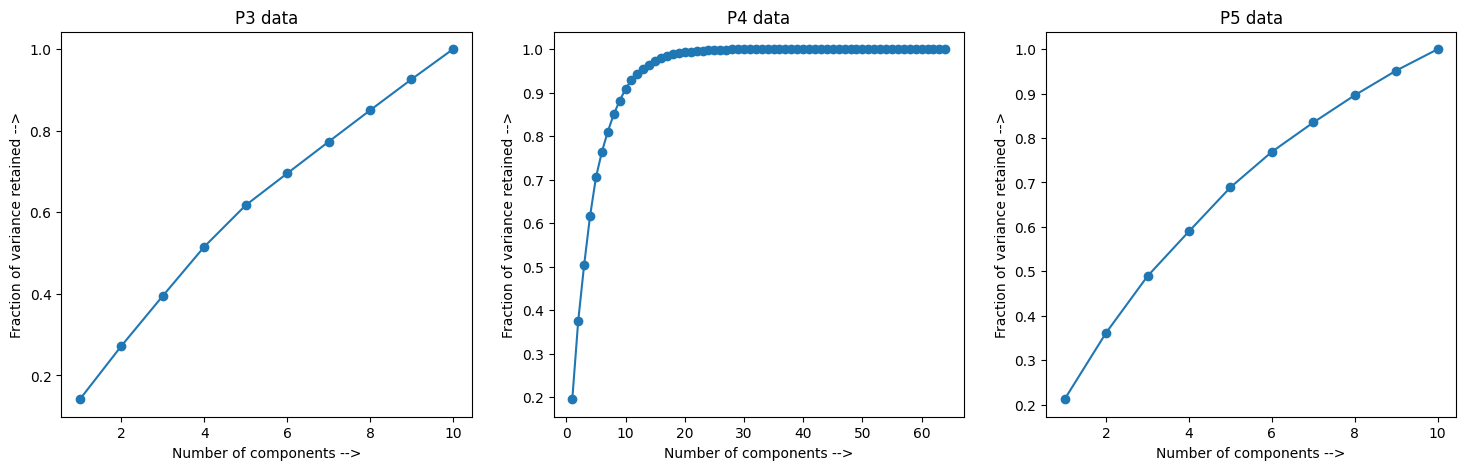

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
_, eigVals = pca(p3["X"])
eigValCumsum = np.cumsum(eigVals)
eigValCumsum = eigValCumsum / eigValCumsum[-1]
ax[0].plot(np.arange(1, len(eigVals) + 1), eigValCumsum, marker='o')
ax[0].set_xlabel("Number of components -->")
ax[0].set_ylabel("Fraction of variance retained -->")
ax[0].set_title("P3 data")

_, eigVals = pca(p4["X"])
eigValCumsum = np.cumsum(eigVals)
eigValCumsum = eigValCumsum / eigValCumsum[-1]
ax[1].plot(np.arange(1, len(eigVals) + 1), eigValCumsum, marker='o')
ax[1].set_xlabel("Number of components -->")
ax[1].set_ylabel("Fraction of variance retained -->")
ax[1].set_title("P4 data")

_, eigVals = pca(p5["X"])
eigValCumsum = np.cumsum(eigVals)
eigValCumsum = eigValCumsum / eigValCumsum[-1]
ax[2].plot(np.arange(1, len(eigVals) + 1), eigValCumsum, marker='o')
ax[2].set_xlabel("Number of components -->")
ax[2].set_ylabel("Fraction of variance retained -->")
ax[2].set_title("P5 data")

plt.show()
